In [1]:
import pandas as pd

import os
import random
import datetime
from dateutil.parser import parse
import numpy as np
import itertools
import string
import time
import csv
import math
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Control Variable

In [2]:
CSV_File = 'billboard_w_song_facts_v4.csv'

#train test split ratio
test_size = 0.2
# current time info

Year = 2018
Quarter = 3
 
# dictionary for regressor type 
MODE = {'default': None,
        'by_rank': 'rank',
        'by_year': 'year'}
JUMP_MODE = {'off': False,
             'on': True}

# New Features

In [3]:
def advanced_insert_feature(df, func = None, feature_name = None):
    if not feature_name:
        raise ('Empty feature')

    new_data = df.apply(lambda x: func(x, feature_name), axis = 1)
    df.insert(df.shape[1], feature_name, new_data)
    
def insert_feature(df, func = None, feature_name = None):
    if not feature_name:
        raise ('Empty feature')

    new_data = df.apply(func, axis = 1)
    df.insert(df.shape[1], feature_name, new_data)

# Features for base model

In [4]:
# helper function
adjusted_diff_time = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75}
def adjust_time_duration(month):
    quarter = (month - 1)//3
    return adjusted_diff_time[quarter]

In [5]:
def difference_year(row_data, year = Year):
    return year - row_data['year']

def adjusted_difference_year(row_data, year = Year):
    return year + adjust_time_duration(Quarter) - row_data['year'] - adjust_time_duration(row_data['weekid'].month)

def log_rank(row_data):
    return np.log(row_data['rank'])

def reverse_rank(row_data):
    return 101 - row_data['rank']

def log_reverse_rank(row_data):
    return np.log(101 - row_data['rank'])

def log_weeks_on_chart(row_data):
    return np.log(row_data['weeks_on_chart'])

def log_continue_week(row_data):
    return np.log(row_data['continue_week'])

def log_jump_time(row_data):
    if row_data['jump_time'] == 0:
        return 0
    else:
        return np.log(row_data['jump_time'])

def log_max_duration(row_data):
    if row_data['max_jump_duration'] == 0:
        return 0
    else:
        return np.log(row_data['max_jump_duration'])
    
def log_popularity(row_data, rule):
    if row_data[rule] == 0:
        return 0
    else:
        return np.log(row_data[rule])

def insert_base_feature(df):
    insert_feature(df, difference_year, 'diff_year')
    insert_feature(df, adjusted_difference_year, 'adjusted_diff_year')
    insert_feature(df, reverse_rank, 'reverse_rank')
    insert_feature(df, log_rank, 'log_rank')
    insert_feature(df, log_reverse_rank, 'log_reverse_rank')
    insert_feature(df, log_weeks_on_chart, 'log_weeks_on_chart')
    insert_feature(df, log_jump_time, 'log_jump_time')
    insert_feature(df, log_max_duration, 'log_max_duration')

# Read Data

In [6]:
df_all = pd.read_csv(CSV_File)
df_all['weekid'] = pd.to_datetime(df_all.weekid, infer_datetime_format = True)
df_train = pd.read_csv('fixed_train_v1.csv')
df_train['weekid'] = pd.to_datetime(df_train.weekid, infer_datetime_format = True)
df_test = pd.read_csv('fixed_test_v1.csv')
df_test['weekid'] = pd.to_datetime(df_test.weekid, infer_datetime_format = True)

# Auxiliary Functions

In [7]:
def print_statistics_error_info(df, model_name, popularity, predicted_popularity):
    print('Mean Absolute Error of' , model_name, 'is', mean_absolute_error(df[popularity], df[predicted_popularity]))
    print('Median Absolute Error of' , model_name, 'is', median_absolute_error(df[popularity], df[predicted_popularity]))
    print('Mean Squared Error of' , model_name, 'is', mean_squared_error(df[popularity], df[predicted_popularity]))

In [8]:
def plot_error_line_by_year(train = df_train, test = None, err_type = 'mean_absolute_error', compared_feature = [('strict_rule', 'predict', 'model_name')]):
    err = {'mean_squared_error': 'Mean Squared Error',
               'mean_absolute_error': 'Mean Absolute Error',
               'median_absolute_error': 'Median Absolute Error'}
    func = {'mean_squared_error': mean_squared_error,
           'mean_absolute_error': mean_absolute_error,
           'median_absolute_error': median_absolute_error}

    plt.figure(figsize=(20, 10), dpi=80)
    predicted_group_by_year=train.groupby('year')
    min_year=df_train['year'].min()
    max_year=df_train['year'].max()+1  
    year = np.arange(min_year, max_year)
    train_error={}
    for pop, predicted_pop, model_name in compared_feature:
        train_error[model_name] = []
        for index, group in predicted_group_by_year:
            train_error[model_name].append(func[err_type](group[pop], group[predicted_pop])) 
        plt.plot(year, train_error[model_name], label=model_name, marker='o', markerfacecolor='w',linestyle='dashed', markersize = 10)
    
    plt.xlabel("Year",fontsize=36)
    plt.ylabel("Mean Absolute Error",fontsize=36)
    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.xticks(np.arange(min_year, max_year+1, 5))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend(loc='upper right', shadow=True, fontsize=24)
    plt.show()

def plot_advanced_error_line_by_year(train = df_train, err_type = 'mean_absolute_error', compared_feature = [('strict_rule', 'predict','model_name', 1)]):
    err = {'mean_squared_error': 'Mean Squared Error',
               'mean_absolute_error': 'Mean Absolute Error',
               'median_absolute_error': 'Median Absolute Error'}
    func = {'mean_squared_error': mean_squared_error,
           'mean_absolute_error': mean_absolute_error,
           'median_absolute_error': median_absolute_error}

    plt.figure(figsize=(20, 10), dpi=80)
    
    min_year=train['year'].min()
    max_year=train['year'].max()+1  
    year = np.arange(min_year, max_year)
    train_error={}
    for pop, predicted_pop, model_name, rank_idx in compared_feature:
        train_error[model_name] = []
        predicted_group_by_year=train.groupby('year')
        for index, group in predicted_group_by_year:
            df_tmp = group.loc[(group[pop] > 0) & (group['rank'] == rank_idx)]
            if df_tmp.shape[0] == 0:
                train_error[model_name].append(-2)
            else:
                train_error[model_name].append(func[err_type](df_tmp[pop], 
                                                          df_tmp[predicted_pop])) 

        
        plt.plot(year, train_error[model_name], label=model_name, marker='o', markerfacecolor='w',linestyle='dashed', markersize = 10)
        plt.xlabel("Year",fontsize=36)
        plt.ylabel("Mean Absolute Error",fontsize=36)
        plt.rc('xtick',labelsize=24)
        plt.rc('ytick',labelsize=24)
        plt.xticks(np.arange(min_year, max_year+1, 5))
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(loc='upper right', shadow=True, fontsize=24)
    
    plt.plot(year, [-1 for _ in year], 'k--')
    
    plt.show()


def plot_error_line_by_rank(train = df_train, test = None, err_type = 'mean_absolute_error', compared_feature = [('strict_rule', 'predict', 'model_name')]):
    err = {'mean_squared_error': 'Mean Squared Error',
               'mean_absolute_error': 'Mean Absolute Error',
               'median_absolute_error': 'Median Absolute Error'}
    func = {'mean_squared_error': mean_squared_error,
           'mean_absolute_error': mean_absolute_error,
           'median_absolute_error': median_absolute_error}

    plt.figure(figsize=(20, 10), dpi=80)
    predicted_group_by_rank=train.groupby('rank')
    rank = np.arange(1, 101)
    train_error={}
    for pop, predicted_pop, model_name in compared_feature:
        train_error[model_name] = []
        for index, group in predicted_group_by_rank:
            train_error[model_name].append(func[err_type](group[pop], group[predicted_pop])) 
        plt.plot(rank, train_error[model_name], label=model_name, marker='o', markerfacecolor = 'w',linestyle='dashed', markersize = 10)
    
    plt.xlabel("Peak Rank",fontsize=36)
    plt.ylabel(err[err_type],fontsize=36)
    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.xticks(np.arange(1, 100, 5))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper right', shadow=True, fontsize=24)
    plt.show()


In [9]:
def plot_error_by_rank(train = df_train, test = None, err_type = 'mean_absolute_error', compared_feature = ['strict_rule', 'predict'], model_name = ''):
    err = {'mean_squared_error': 'Mean Squared Error',
           'mean_absolute_error': 'Mean Absolute Error',
           'median_absolute_error': 'Median Absolute Error'}
    func = {'mean_squared_error': mean_squared_error,
           'mean_absolute_error': mean_absolute_error,
           'median_absolute_error': median_absolute_error}

    if err_type not in err.keys():
        print('Please enter valid error type')
        return

    predicted_group_by_rank=train.groupby('rank')
    train_rank_error=[]
    for index, group in predicted_group_by_rank:
        train_rank_error.append(func[err_type](group[compared_feature[0]], group[compared_feature[1]]))
    
    plt.figure(figsize=(20, 6), dpi=80)
    x = np.arange(1, 101)

    if test is None:
        plt.bar(x + 0.1, train_rank_error, color = 'green', width = 0.8, label='train')
    else:
        predicted_group_by_rank=test.groupby('rank')
        test_rank_error = []
        for index, group in predicted_group_by_rank:
            test_rank_error.append(func[err_type](group[compared_feature[0]], group[compared_feature[1]]))
            
        plt.bar(x + 0.1, train_rank_error, color = 'green', width = 0.4, label='train')
        plt.bar(x + 0.5, test_rank_error, color = 'orange', width = 0.4, label='test')
    plt.xticks(np.arange(1, 101, 5))
    plt.xlabel("Peak Rank",fontsize=18)
    plt.ylabel("Mean Absolute Error",fontsize=18)
    
#     plt.title("Mean Absolute Error by Rank (" + model_name + ")",fontsize=18)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.show()

def plot_error_by_year(train = df_train, test = None, err_type = 'mean_absolute_error', compared_feature = ['strict_rule', 'predict'], model_name = ''):
    err = {'mean_squared_error': 'Mean Squared Error',
           'mean_absolute_error': 'Mean Absolute Error',
           'median_absolute_error': 'Median Absolute Error'}
    func = {'mean_squared_error': mean_squared_error,
           'mean_absolute_error': mean_absolute_error,
           'median_absolute_error': median_absolute_error}

    
    
    predicted_group_by_rank=train.groupby('year')
    min_year=df_train['year'].min()
    max_year=df_train['year'].max()+1  
    year = np.arange(min_year, max_year)
    train_rank_error=[]
    for index, group in predicted_group_by_rank:
        train_rank_error.append(mean_absolute_error(group[compared_feature[0]], group[compared_feature[1]])) 
    
    plt.figure(figsize=(20, 6), dpi=80)

    if test is None:
        plt.bar(year + 0.1, train_rank_error, color = 'green', width = 0.8, label='train')
    else:
        predicted_group_by_rank=test.groupby('year')
        test_rank_error = []
        for index, group in predicted_group_by_rank:
            test_rank_error.append(mean_absolute_error(group[compared_feature[0]], group[compared_feature[1]]))

        plt.bar(year + 0.1, train_rank_error, color = 'green', width = 0.4, label='train')
        plt.bar(year + 0.5, test_rank_error, color = 'orange', width = 0.4, label='test')
    plt.xlabel("Year",fontsize=18)
    plt.ylabel("Mean Absolute Error",fontsize=18)
#     plt.title("Mean Absolute Error by Year (Base Model)",fontsize=18)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.xticks(np.arange(min_year, max_year+1, 5))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.show()

# Linear Regression Base Model
$
\text{popularity} = C_i\text{(reverse_rank)}^{C_r}(\text{weeks_on_chart})^{C_w}e^{C_t (\text{diff_year})}
$


$$
\begin{align*}
\log(\text{popularity}) =& \log C_i + C_r\log(\text{reverse_rank}) + C_w\log(\text{weeks_on_chart}) + {C_t (\text{diff_year})}
\end{align*}
$$

In [10]:
def model_linear_regression(train = df_train, x_features = None, y_feature = None, intercept = True):
    x_train = train[x_features].values
    y_train = train[y_feature].values
    log_y_train = train[y_feature].apply(lambda x: 0 if x == 0 else np.log(x)).values
    regr = LinearRegression(fit_intercept=intercept)
    regr.fit(x_train, log_y_train)
    
    return regr

In [11]:
def predict_value_by_linear_regression(row_data, mode, jump_mode):
    feature = MODE[mode]
    jump = row_data['jump_time'] != 0
    x_val = row_data[lr_x_features].values
    val = None
    
    if mode == 'default':
        if not JUMP_MODE[jump_mode]:
            val = np.exp(lr_regr[mode][jump_mode].predict([x_val]))
        else:
            val = np.exp(lr_regr[mode][jump_mode][jump].predict([x_val]))
    else:
        key = row_data[feature]
        if not JUMP_MODE[jump_mode]:
            val = np.exp(lr_regr[mode][jump_mode][key].predict([x_val]))
        else:
            print('jump mode')
            val = np.exp(lr_regr[mode][jump_mode][jump][key].predict([x_val]))

    if val > 100:
        val = 100
    elif val < 0:
        val = 0
    else:
        val = val.round(decimals = 0)

    return val

# Possible Features

In [12]:
possible_x_features = [['log_reverse_rank', 'log_weeks_on_chart', 'diff_year']]
possible_y_features = ['strict_rule', 'popularity']

# $\text{Base Model - Linear Regression}$

In [13]:
lr_regr = {
    'default': {
        'off': None,
        'on': {
            False: None,
            True: None
        }
    },
    'by_rank': {
        'off': {},
        'on': {
            False: {},
            True: {}
        }
    },
    'by_year': {
        'off': {},
        'on': {
            False: {},
            True: {}
        }
    }
}

## default mode

In [19]:
mode = 'default'
jump_mode = 'off'
lr_x_features = possible_x_features[0]
lr_y_feature = possible_y_features[0]
for lr_y_feature in possible_y_features:
    print('mode: {}, jump_mode: {}\nx: {}\ny: {}'.format(mode, jump_mode, ' '.join(lr_x_features), lr_y_feature))
    lr_regr[mode][jump_mode] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0)] ,
                                                    x_features = lr_x_features,
                                                    y_feature = lr_y_feature,
                                                    intercept = True)
    predict_feature_name = lr_y_feature + '_pred_by_lr' 
    df_train[predict_feature_name] = df_train.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)
    df_test[predict_feature_name] = df_test.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)

    # Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
    print('train')
    print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression base model', lr_y_feature, predict_feature_name)
    print('\n test')
    print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression base model', lr_y_feature, predict_feature_name)

    # plot_error_by_rank(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr'], model_name = '')
    # plot_error_by_year(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr'], model_name = '')

    print(lr_regr[mode][jump_mode].coef_)
    print(lr_regr[mode][jump_mode].intercept_)

mode: default, jump_mode: off
x: log_reverse_rank log_weeks_on_chart diff_year
y: strict_rule
train
Mean Absolute Error of linear regression base model is 12.5276515745
Median Absolute Error of linear regression base model is 10.0
Mean Squared Error of linear regression base model is 256.834560551

 test
Mean Absolute Error of linear regression base model is 12.4773584906
Median Absolute Error of linear regression base model is 10.0
Mean Squared Error of linear regression base model is 252.371069182
[ 0.19943711  0.09391865 -0.02354817]
3.198026436
mode: default, jump_mode: off
x: log_reverse_rank log_weeks_on_chart diff_year
y: popularity
train
Mean Absolute Error of linear regression base model is 12.5475340326
Median Absolute Error of linear regression base model is 10.0
Mean Squared Error of linear regression base model is 258.259093952

 test
Mean Absolute Error of linear regression base model is 12.3904506917
Median Absolute Error of linear regression base model is 10.0
Mean Squa

# $\text{Base Model - Linear Regression}_r$
- Build the linear regression model for each rank
- Predict the song popularity
 

In [20]:
mode = 'by_rank'
jump_mode = 'off'
lr_x_features = possible_x_features[0]
lr_y_feature = possible_y_features[0]
for lr_y_feature in possible_y_features:
    print('mode: {}, jump_mode: {}\nx: {}\ny: {}'.format(mode, jump_mode, lr_x_features, lr_y_feature))

    for rank in range(1, 101):
        lr_regr[mode][jump_mode][rank] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['rank'] == rank)] ,
                                                           x_features = lr_x_features,
                                                           y_feature = lr_y_feature,
                                                           intercept = True)
    predict_feature_name = lr_y_feature + '_pred_by_lr_r' 
    df_train[predict_feature_name] = df_train.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)
    df_test[predict_feature_name] = df_test.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)

    # Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
    print('train')
    print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression_r base model', lr_y_feature, predict_feature_name)
    print('\n test')
    print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression_r base model', lr_y_feature, predict_feature_name)

    # plot_error_by_rank(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr_r'], model_name = '')
    # plot_error_by_year(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr_r'], model_name = '')

mode: by_rank, jump_mode: off
x: ['log_reverse_rank', 'log_weeks_on_chart', 'diff_year']
y: strict_rule
train
Mean Absolute Error of linear regression_r base model is 10.9332602225
Median Absolute Error of linear regression_r base model is 9.0
Mean Squared Error of linear regression_r base model is 199.489895034

 test
Mean Absolute Error of linear regression_r base model is 11.2232704403
Median Absolute Error of linear regression_r base model is 9.0
Mean Squared Error of linear regression_r base model is 205.067295597
mode: by_rank, jump_mode: off
x: ['log_reverse_rank', 'log_weeks_on_chart', 'diff_year']
y: popularity
train
Mean Absolute Error of linear regression_r base model is 10.8300044633
Median Absolute Error of linear regression_r base model is 9.0
Mean Squared Error of linear regression_r base model is 198.984434278

 test
Mean Absolute Error of linear regression_r base model is 10.8654618474
Median Absolute Error of linear regression_r base model is 9.0
Mean Squared Error of

# $\text{Base Model - Linear Regression}_y$
- Build the linear regression model for each year
- Predict the song popularity
 

In [21]:
mode = 'by_year'
jump_mode = 'off'
lr_x_features = possible_x_features[0]

for lr_y_feature in possible_y_features:
    print('mode: {}, jump_mode: {}\nx: {}\ny: {}'.format(mode, jump_mode, lr_x_features, lr_y_feature))

    for year in range(1958, 2018):
        lr_regr[mode][jump_mode][year] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['year'] == year)] ,
                                                           x_features = lr_x_features,
                                                           y_feature = lr_y_feature,
                                                           intercept = True)
    predict_feature_name = lr_y_feature + '_pred_by_lr_y' 
    df_train[predict_feature_name] = df_train.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)
    df_test[predict_feature_name] = df_test.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)

    # Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
    print('train')
    print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression_y base model', lr_y_feature, predict_feature_name)
    print('\n test')
    print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression_y base model', lr_y_feature, predict_feature_name)

    # plot_error_by_rank(train = df_train.loc[df_train[lr_y_feature] > 0], test = df_test.loc[df_test[lr_y_feature] > 0], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr_y'], model_name = '')
    # plot_error_by_year(train = df_train.loc[df_train[lr_y_feature] > 0], test = df_test.loc[df_test[lr_y_feature] > 0], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr_y'], model_name = '')

mode: by_year, jump_mode: off
x: ['log_reverse_rank', 'log_weeks_on_chart', 'diff_year']
y: strict_rule
train
Mean Absolute Error of linear regression_y base model is 11.299310669
Median Absolute Error of linear regression_y base model is 9.0
Mean Squared Error of linear regression_y base model is 209.847172176

 test
Mean Absolute Error of linear regression_y base model is 11.4289308176
Median Absolute Error of linear regression_y base model is 9.0
Mean Squared Error of linear regression_y base model is 213.208176101
mode: by_year, jump_mode: off
x: ['log_reverse_rank', 'log_weeks_on_chart', 'diff_year']
y: popularity
train
Mean Absolute Error of linear regression_y base model is 11.2798482482
Median Absolute Error of linear regression_y base model is 9.0
Mean Squared Error of linear regression_y base model is 212.987279625

 test
Mean Absolute Error of linear regression_y base model is 11.2099509148
Median Absolute Error of linear regression_y base model is 9.0
Mean Squared Error of 

strict_rule


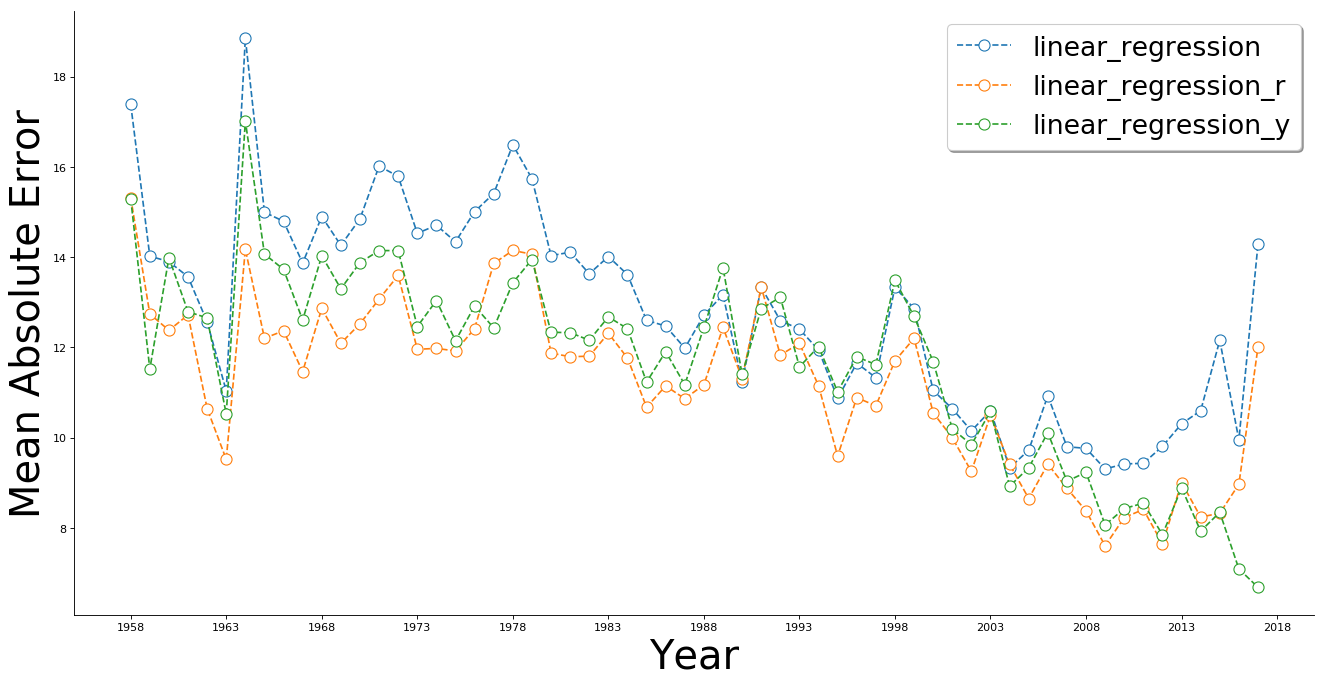

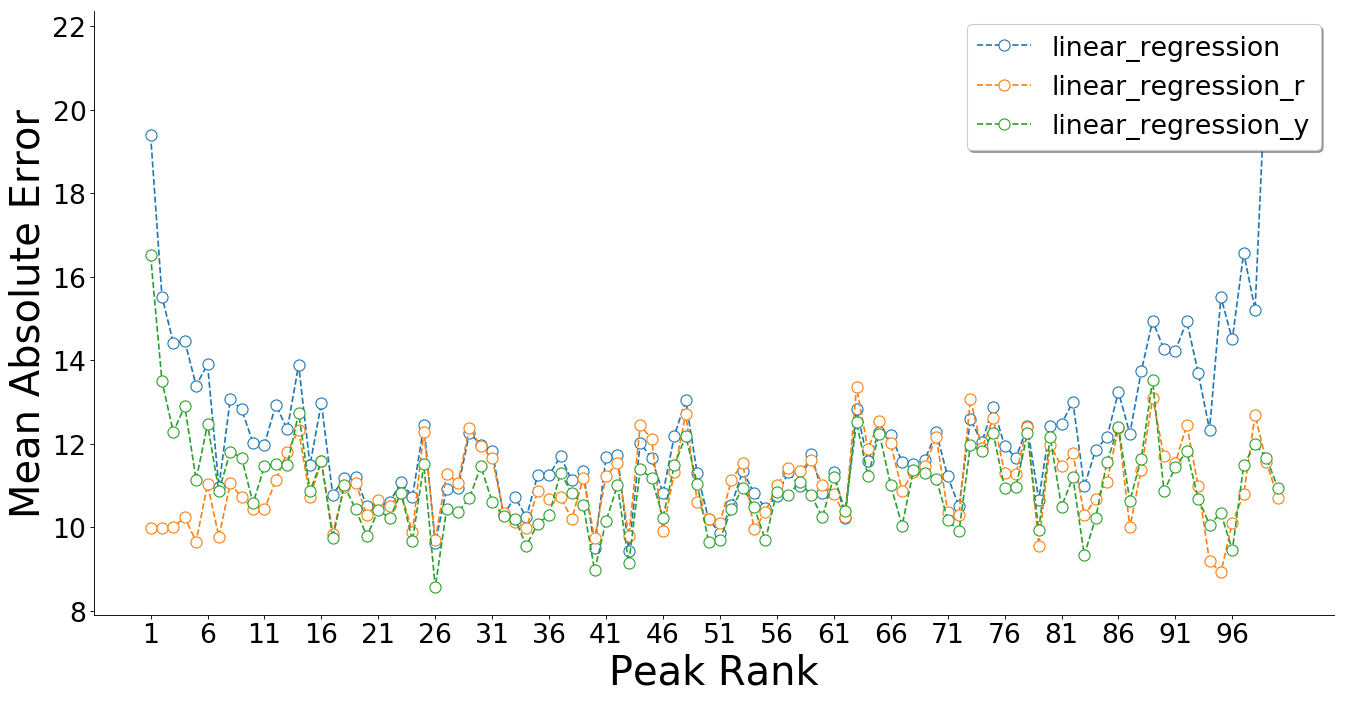

popularity


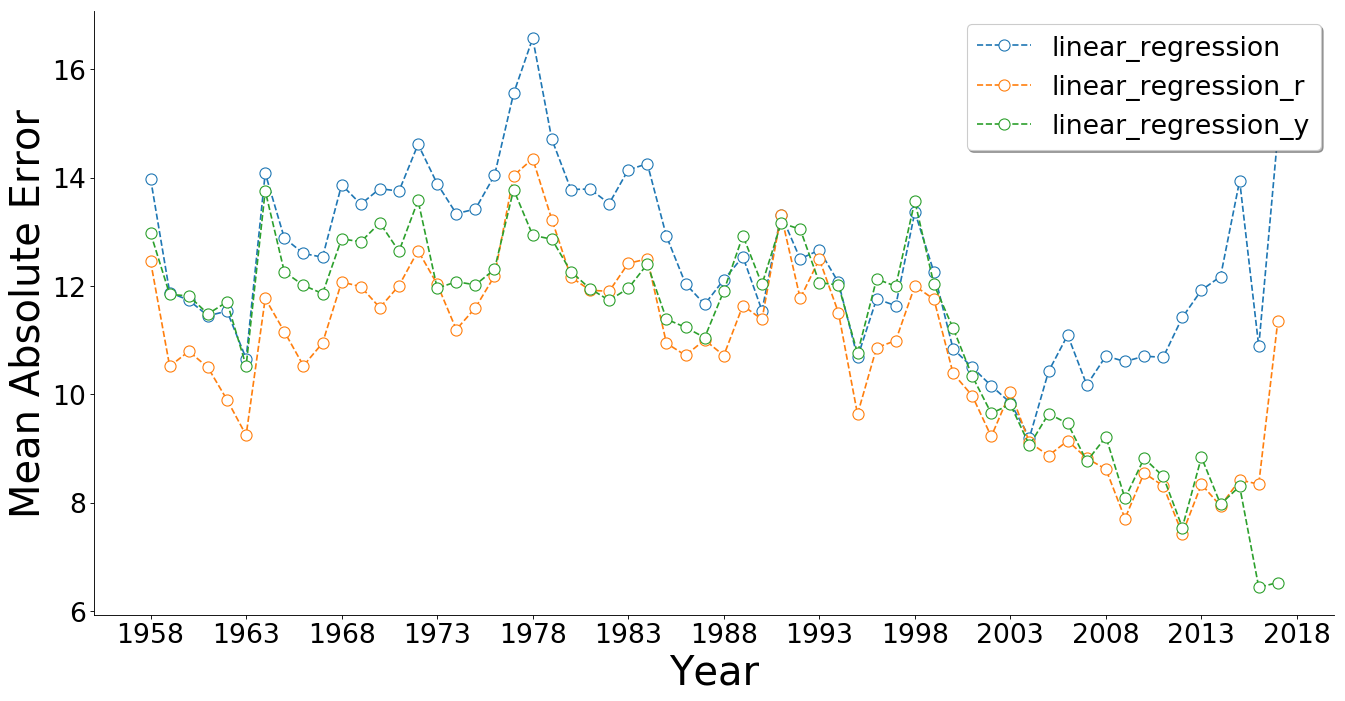

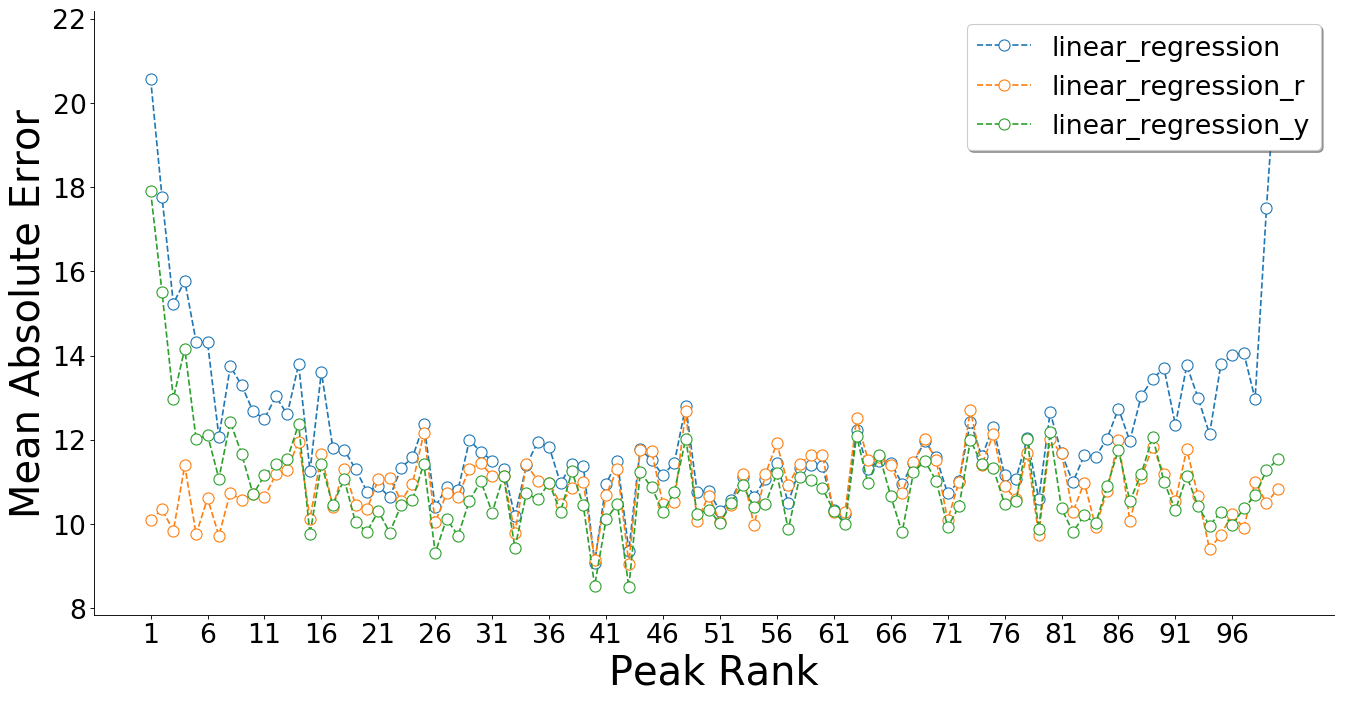

In [22]:
for lr_y_feature in ['strict_rule', 'popularity']:
    print(lr_y_feature)

    plot_error_line_by_year(df_train.loc[df_train[lr_y_feature] > 0], compared_feature = [(lr_y_feature, lr_y_feature + '_pred_by_lr', 'linear_regression'),
                                                                                          (lr_y_feature, lr_y_feature + '_pred_by_lr_r', 'linear_regression_r'),
                                                                                          (lr_y_feature, lr_y_feature + '_pred_by_lr_y', 'linear_regression_y')])

    plot_error_line_by_rank(df_train.loc[df_train[lr_y_feature] > 0], compared_feature = [(lr_y_feature, lr_y_feature + '_pred_by_lr', 'linear_regression'),
                                                                                          (lr_y_feature, lr_y_feature + '_pred_by_lr_r', 'linear_regression_r'),
                                                                                          (lr_y_feature, lr_y_feature + '_pred_by_lr_y', 'linear_regression_y')])

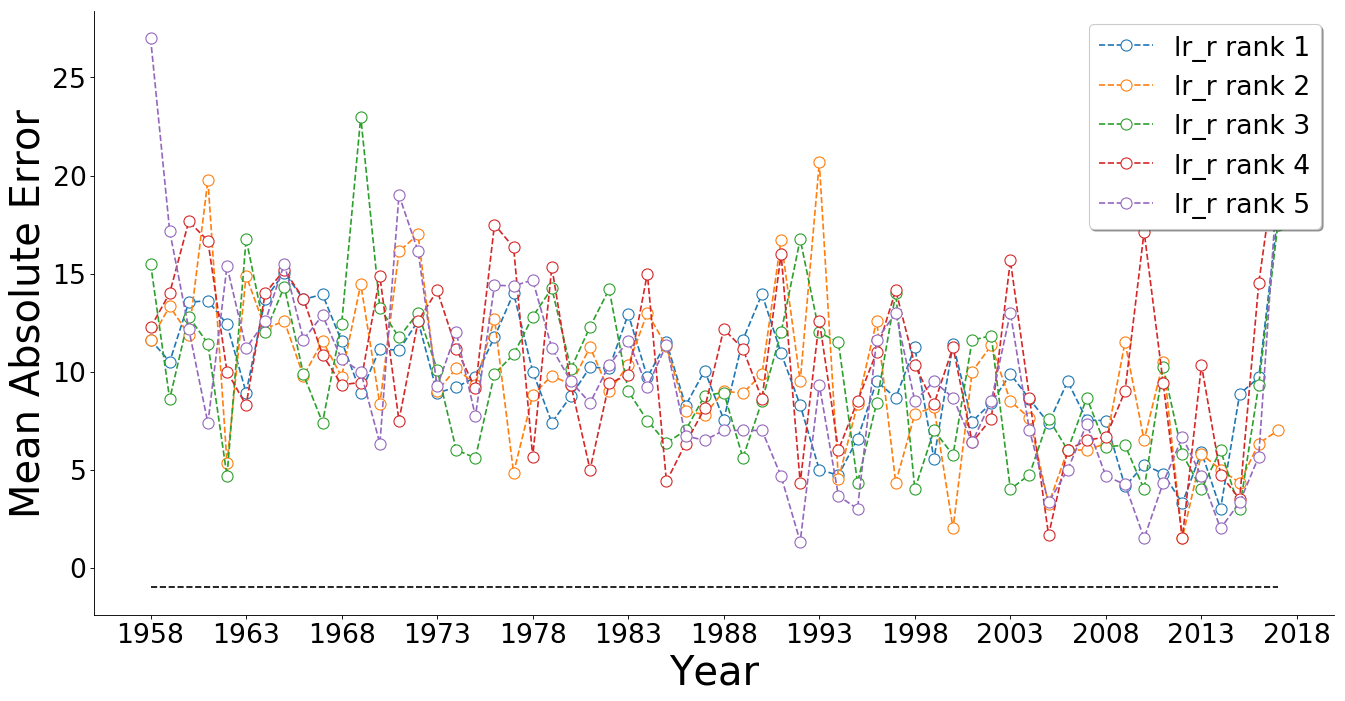

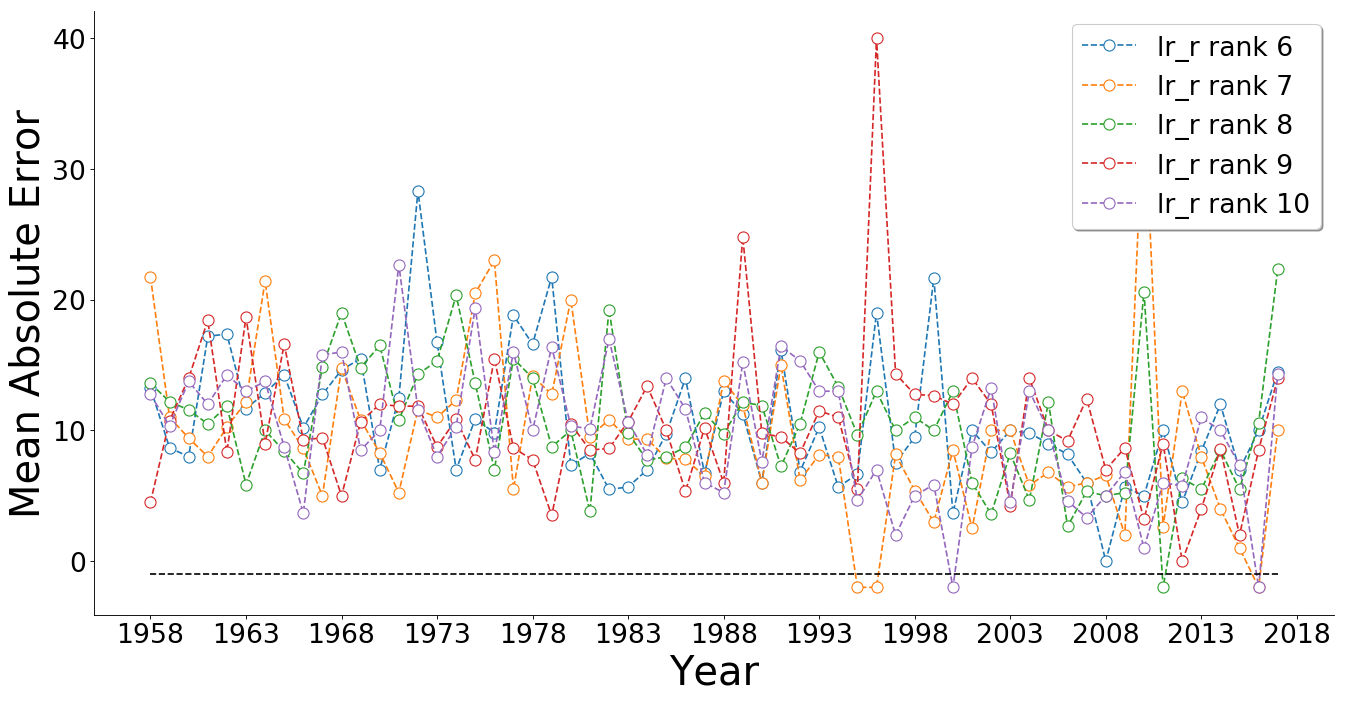

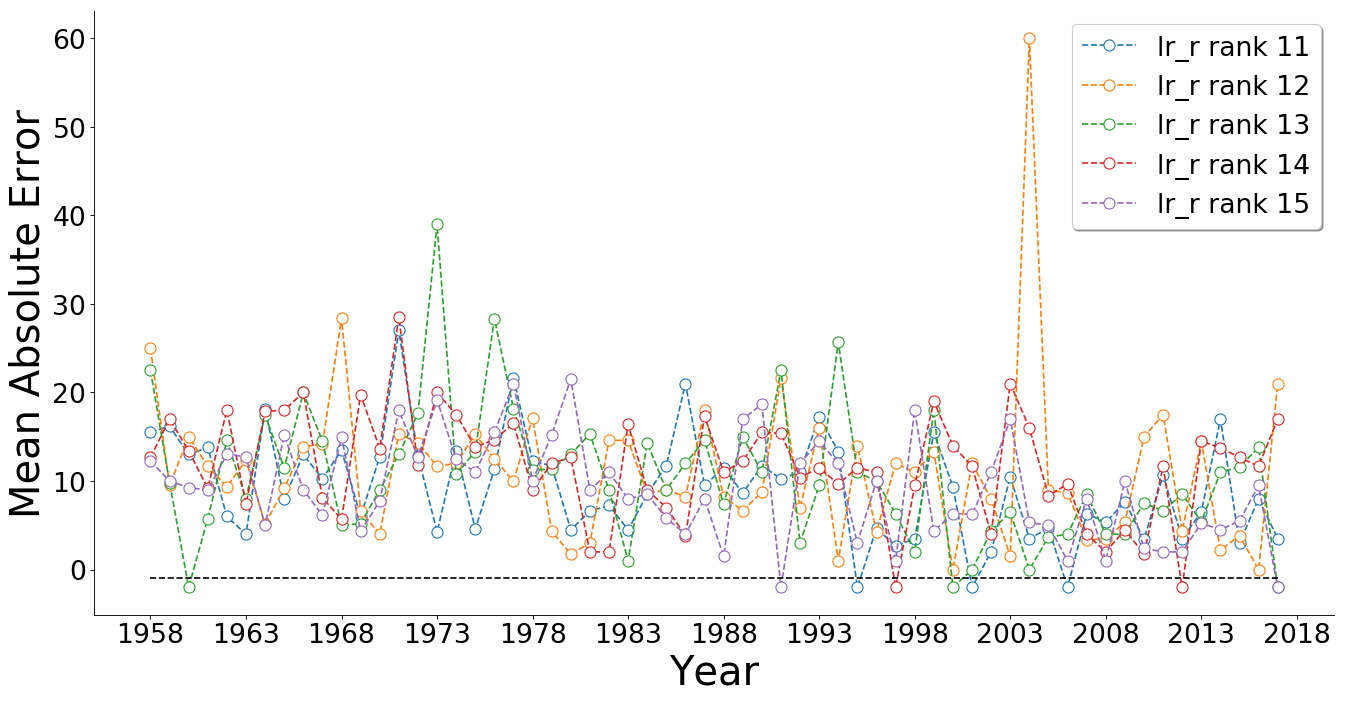

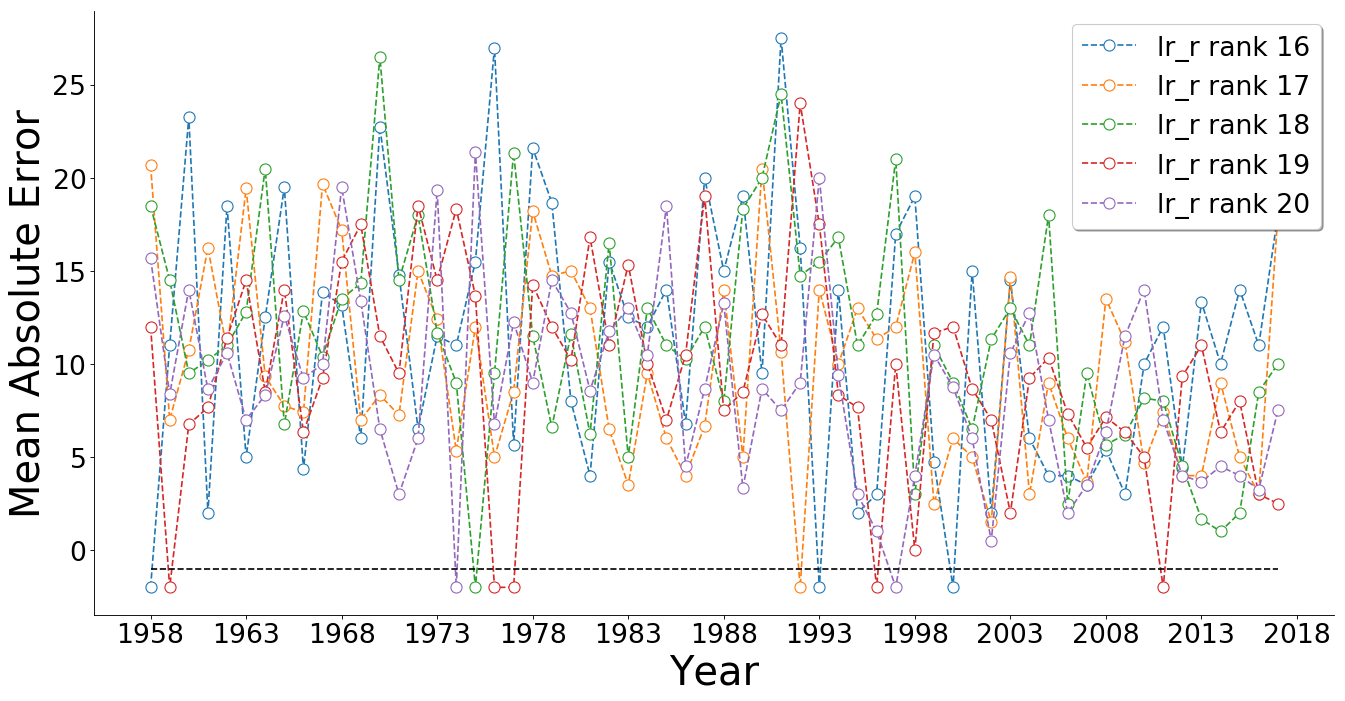

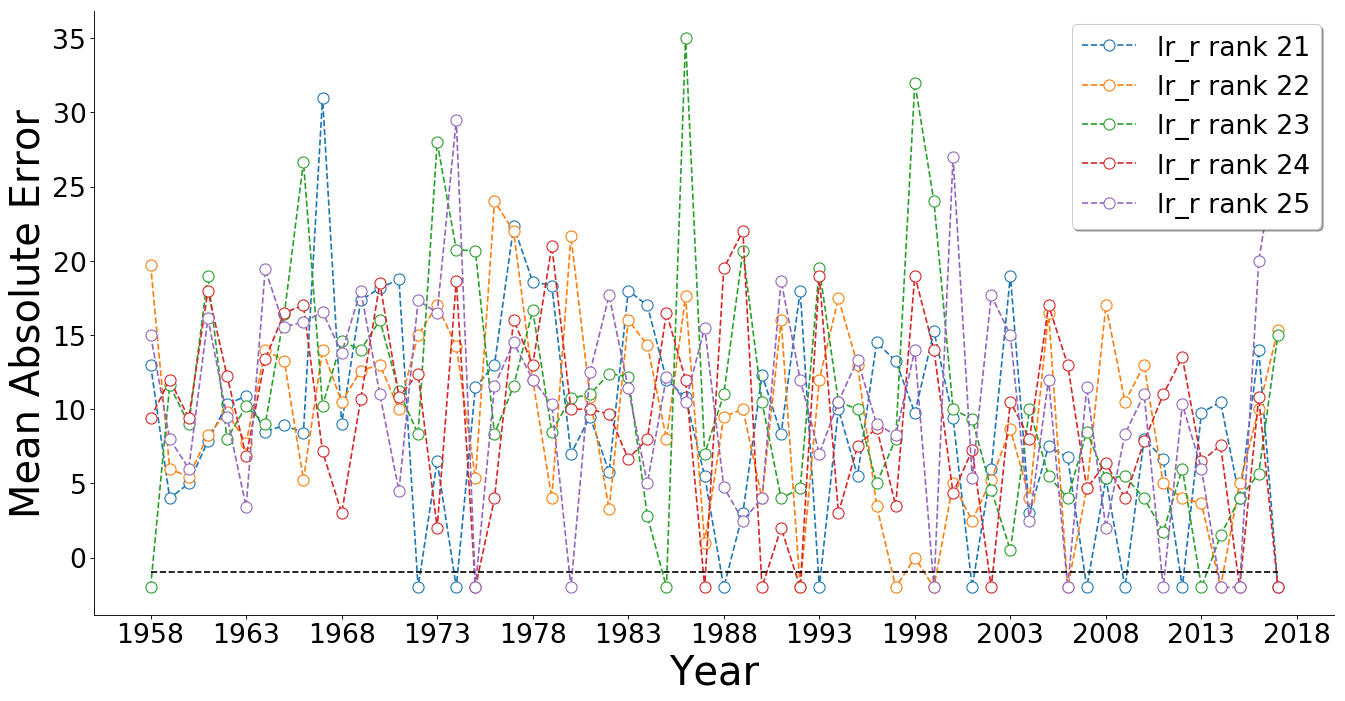

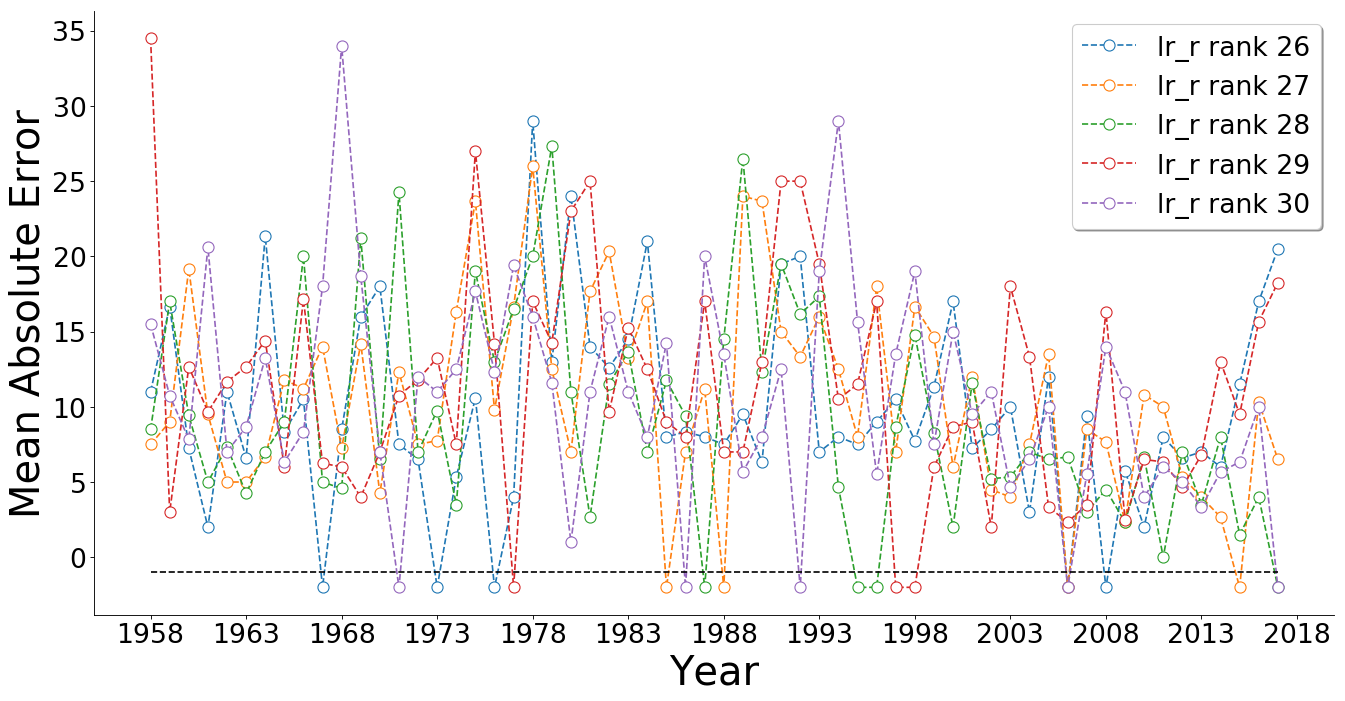

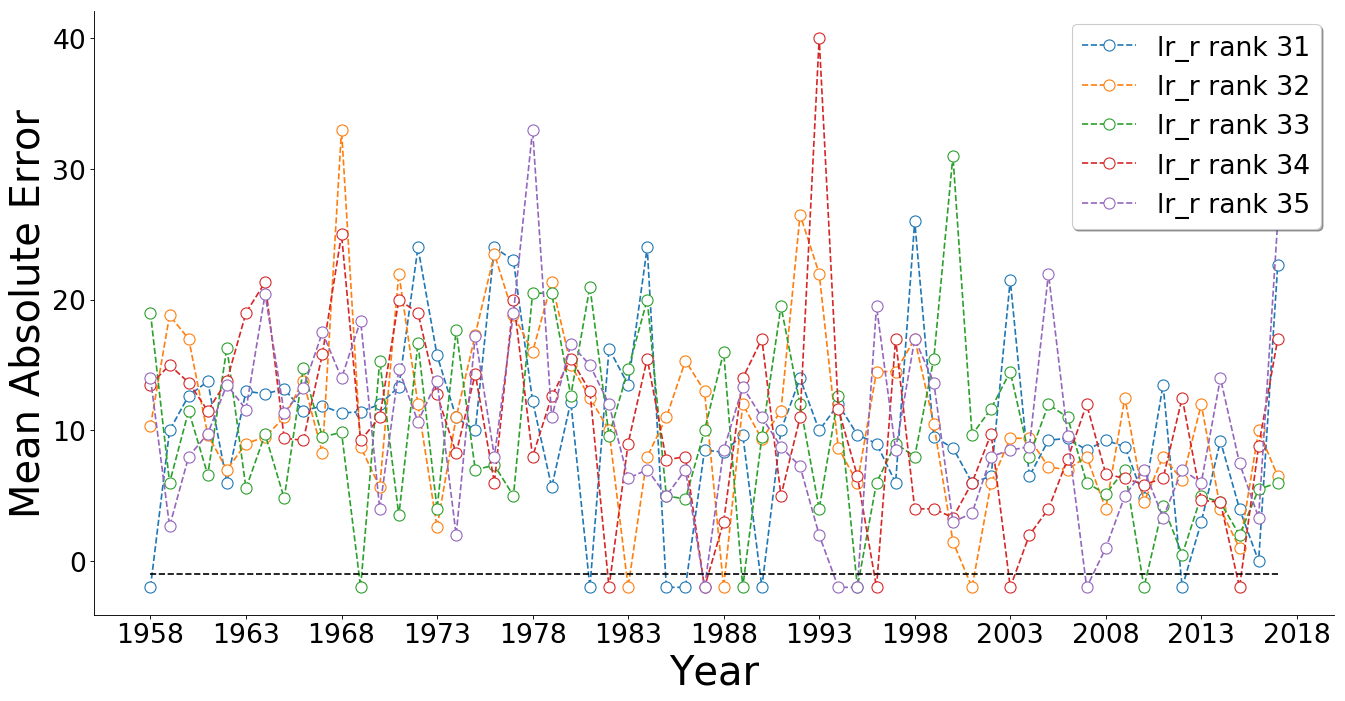

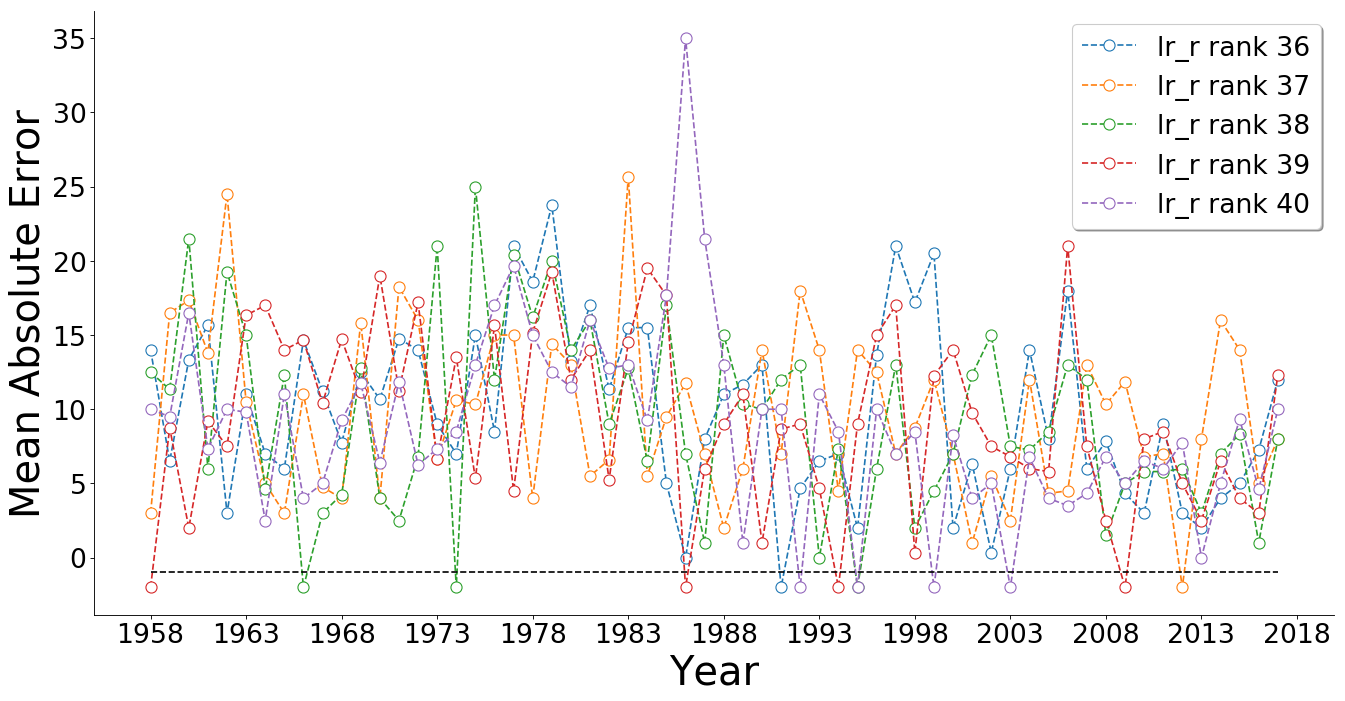

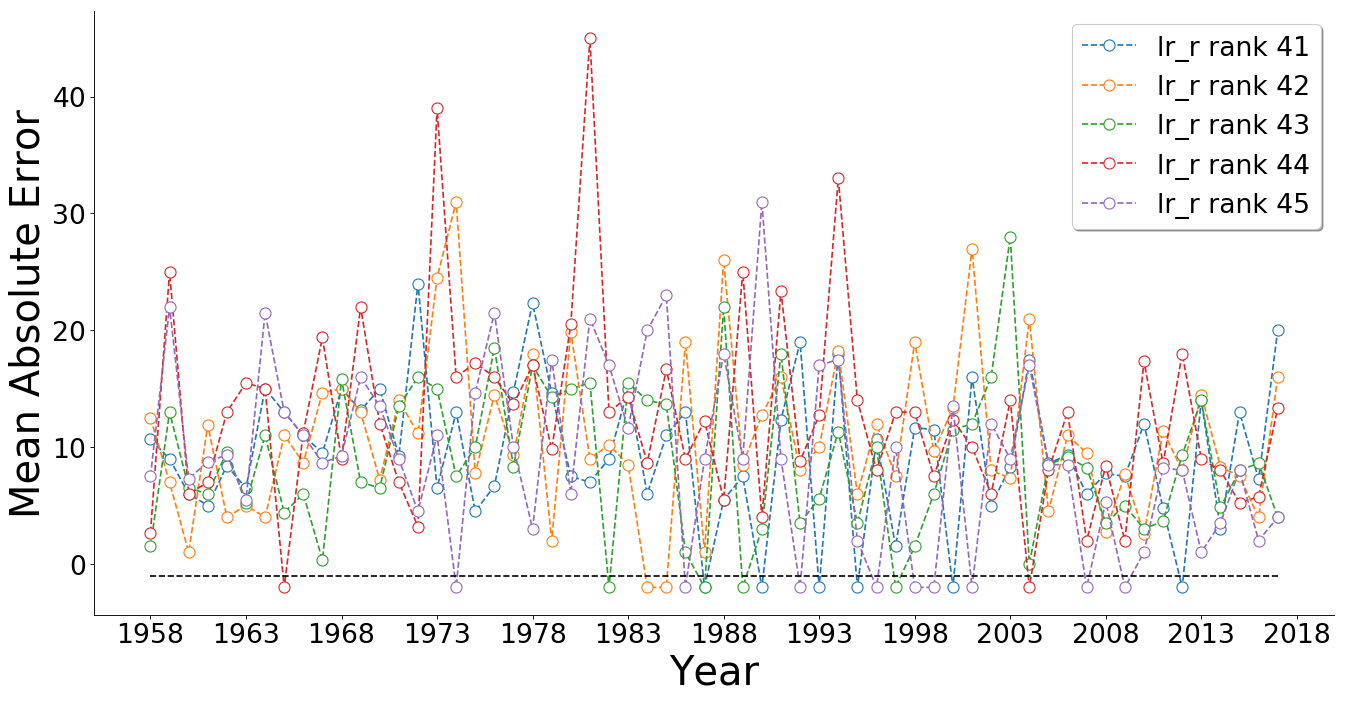

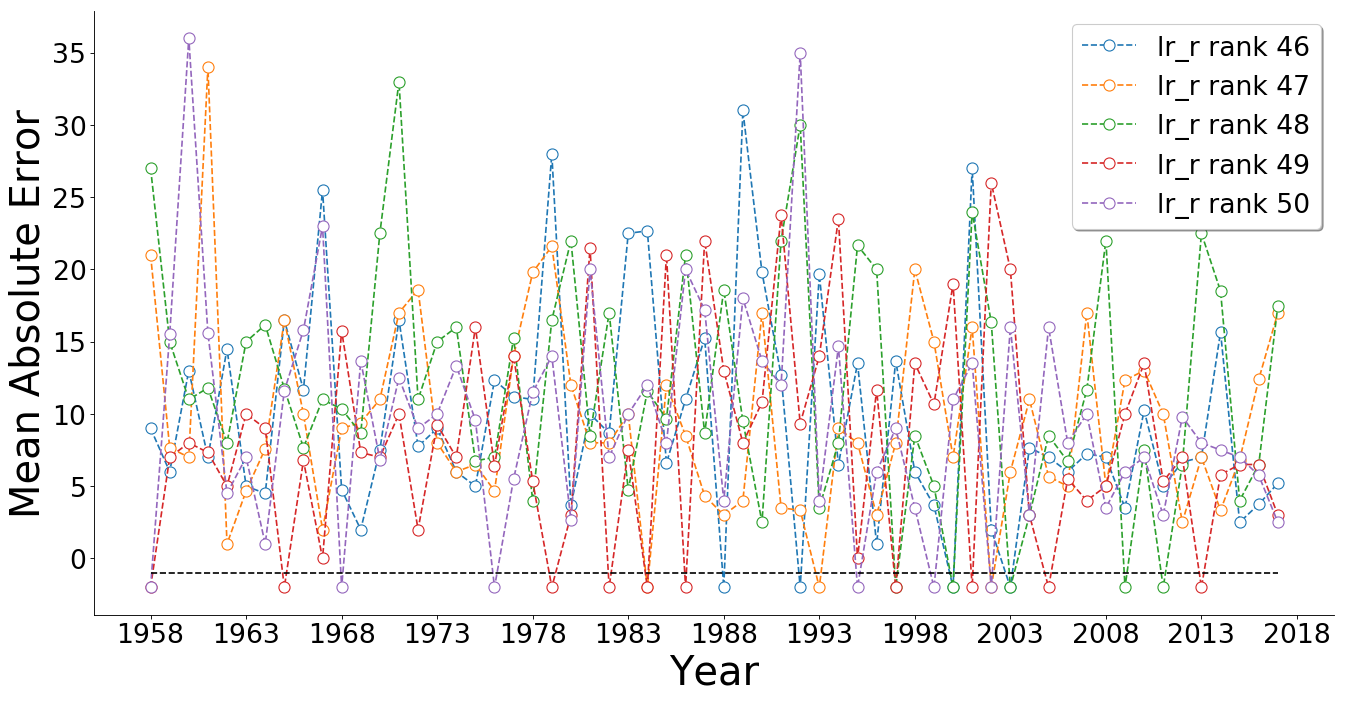

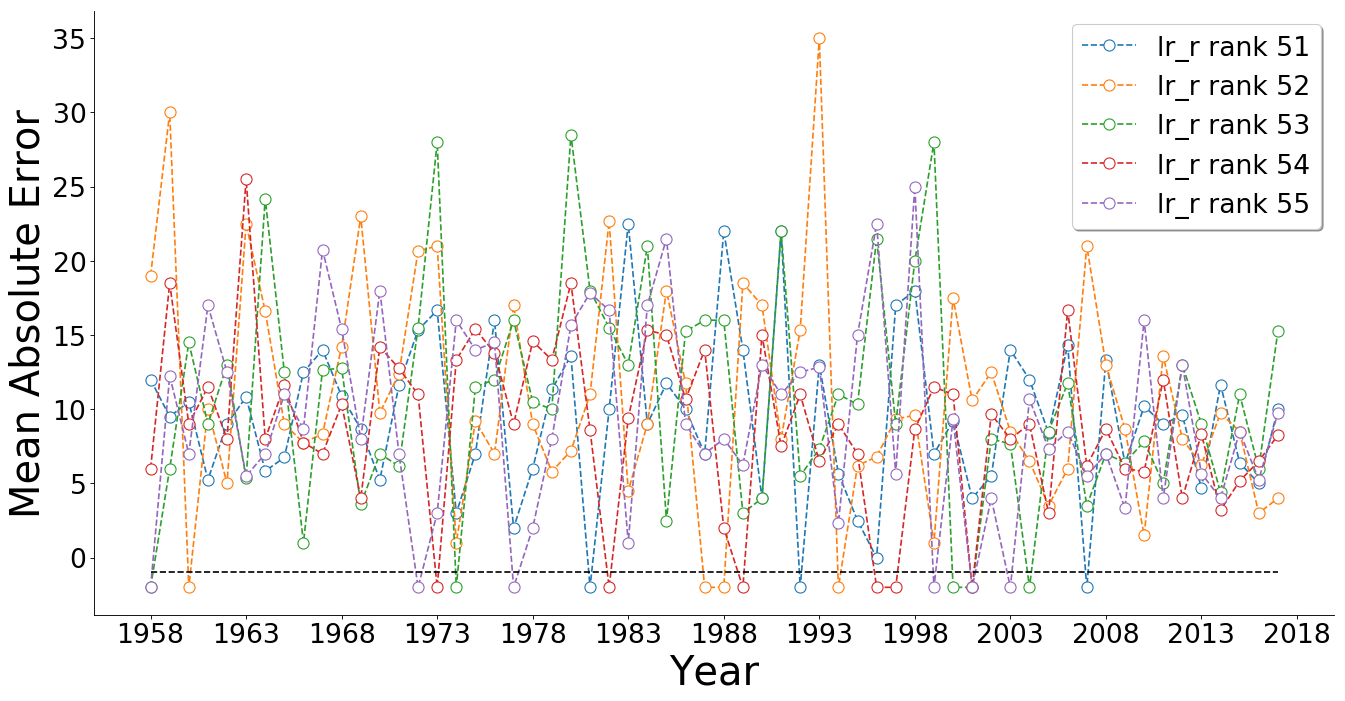

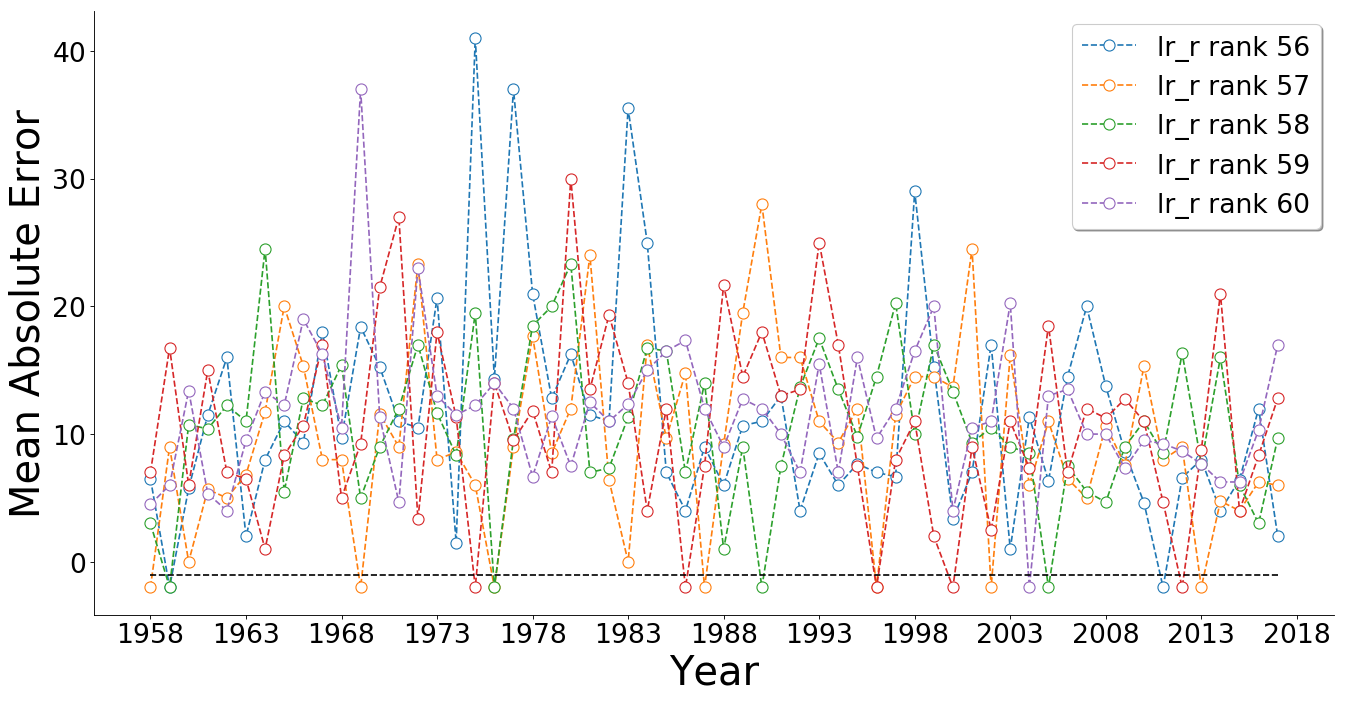

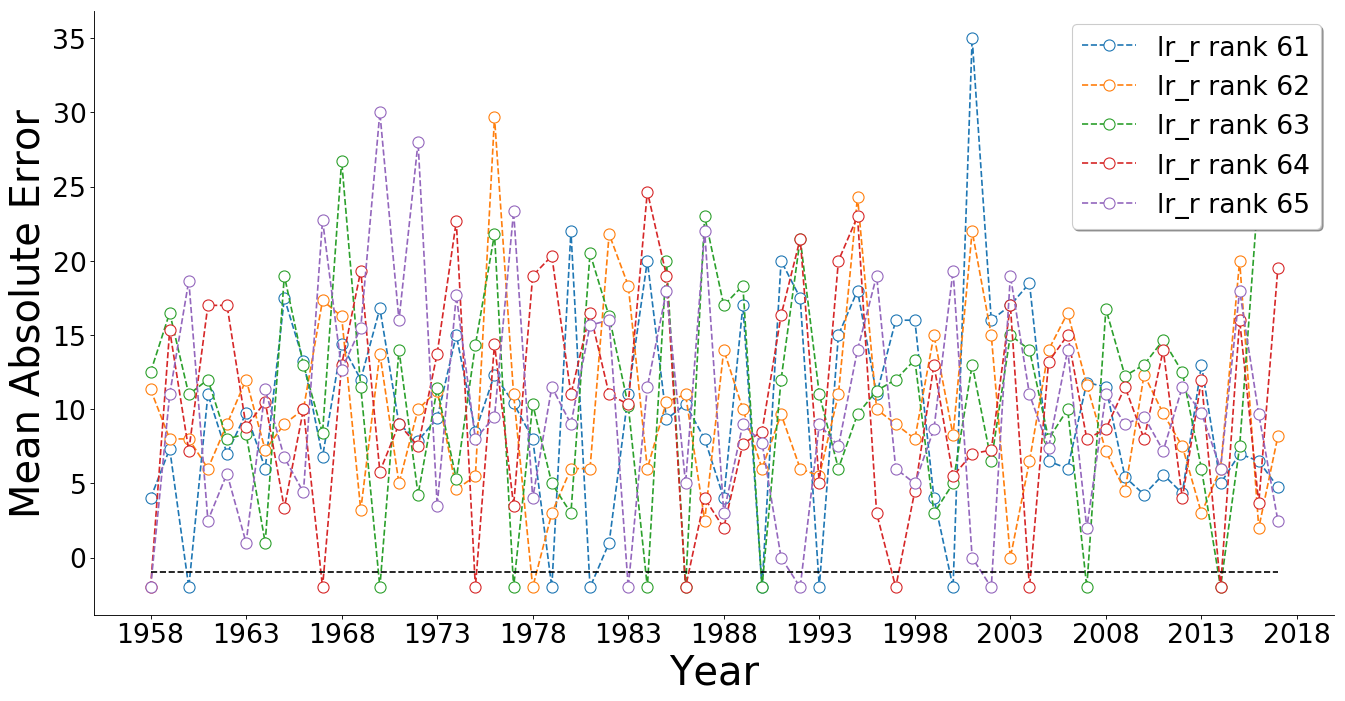

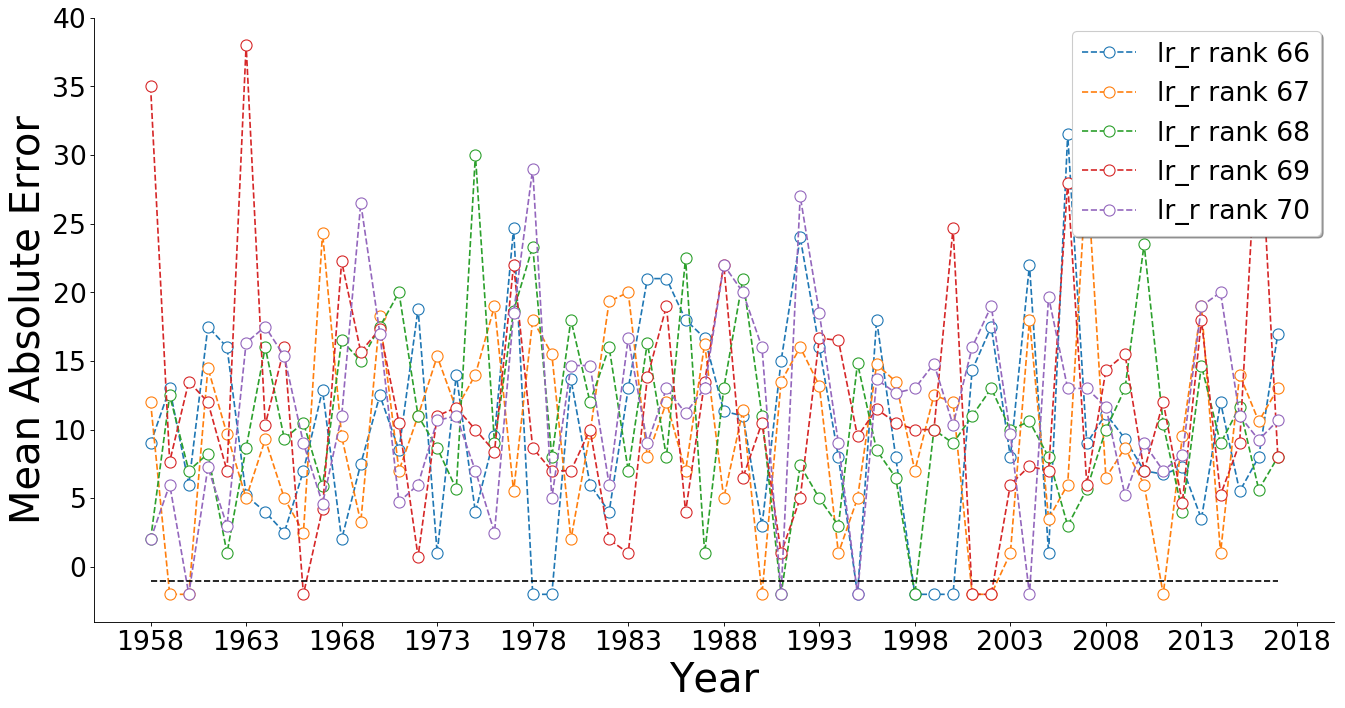

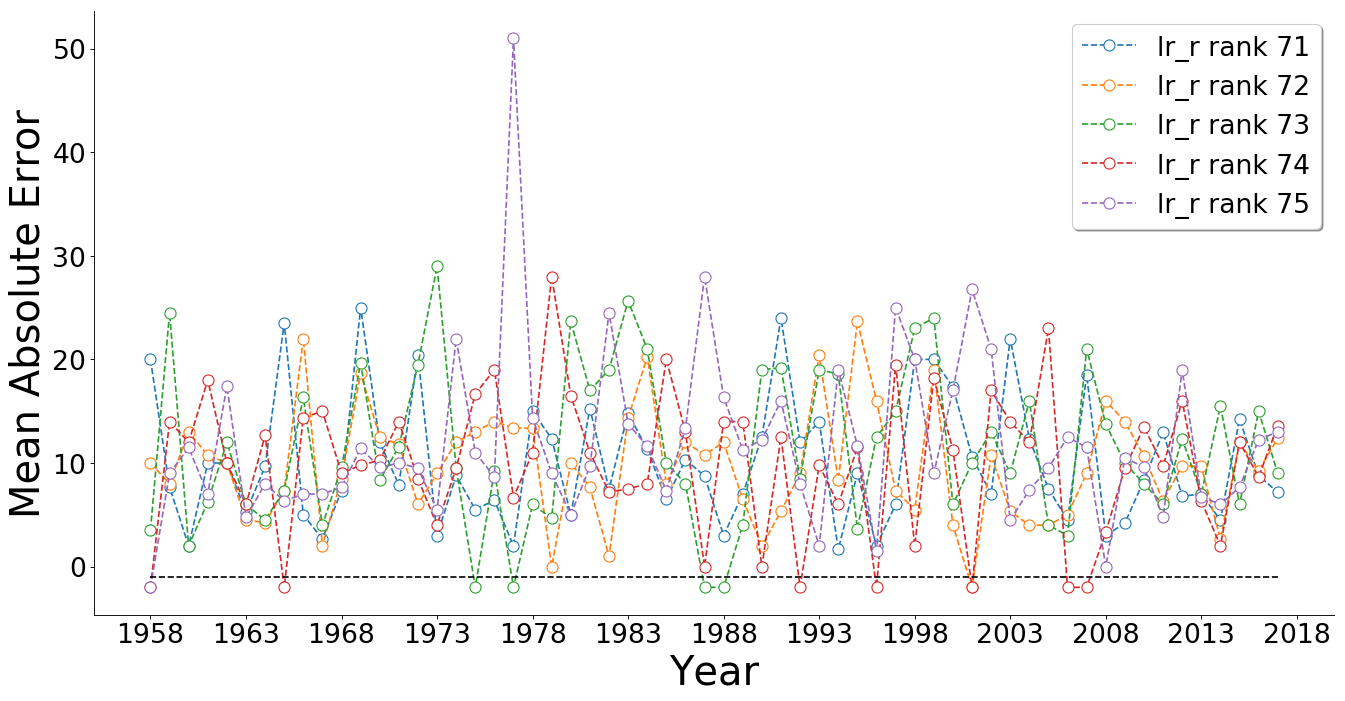

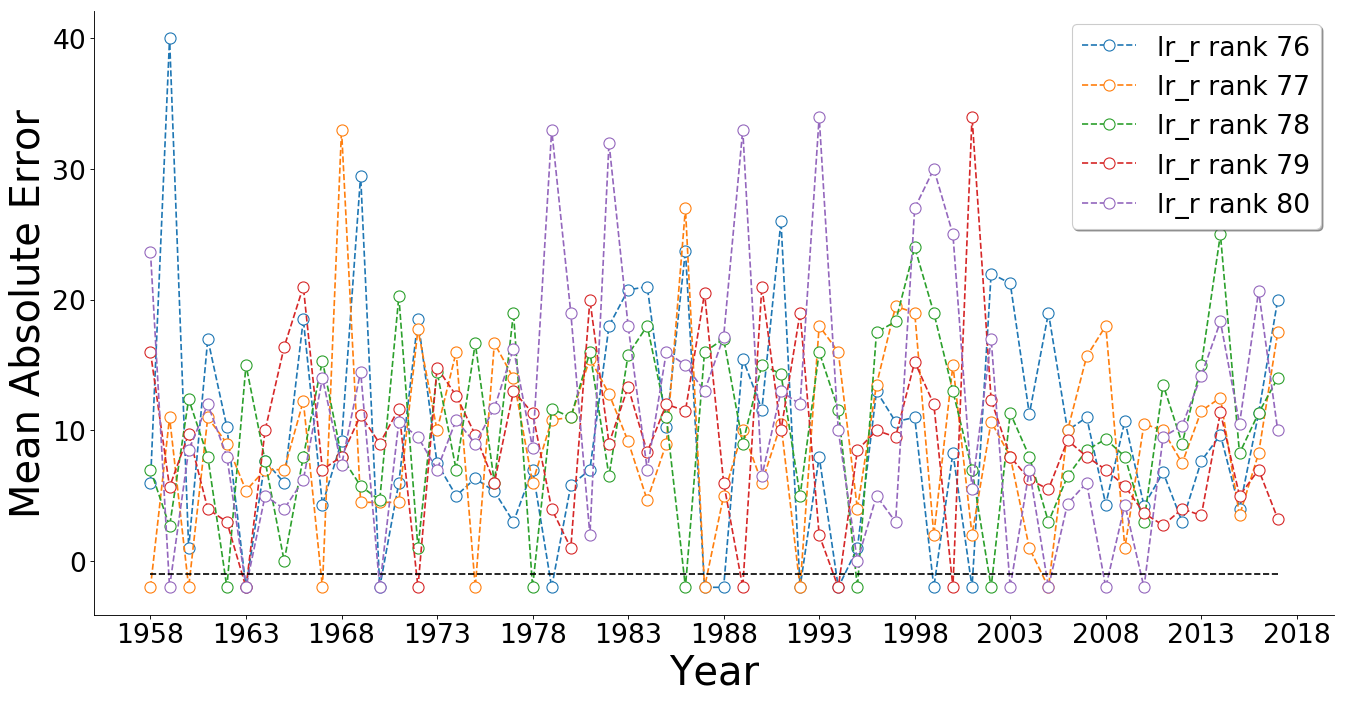

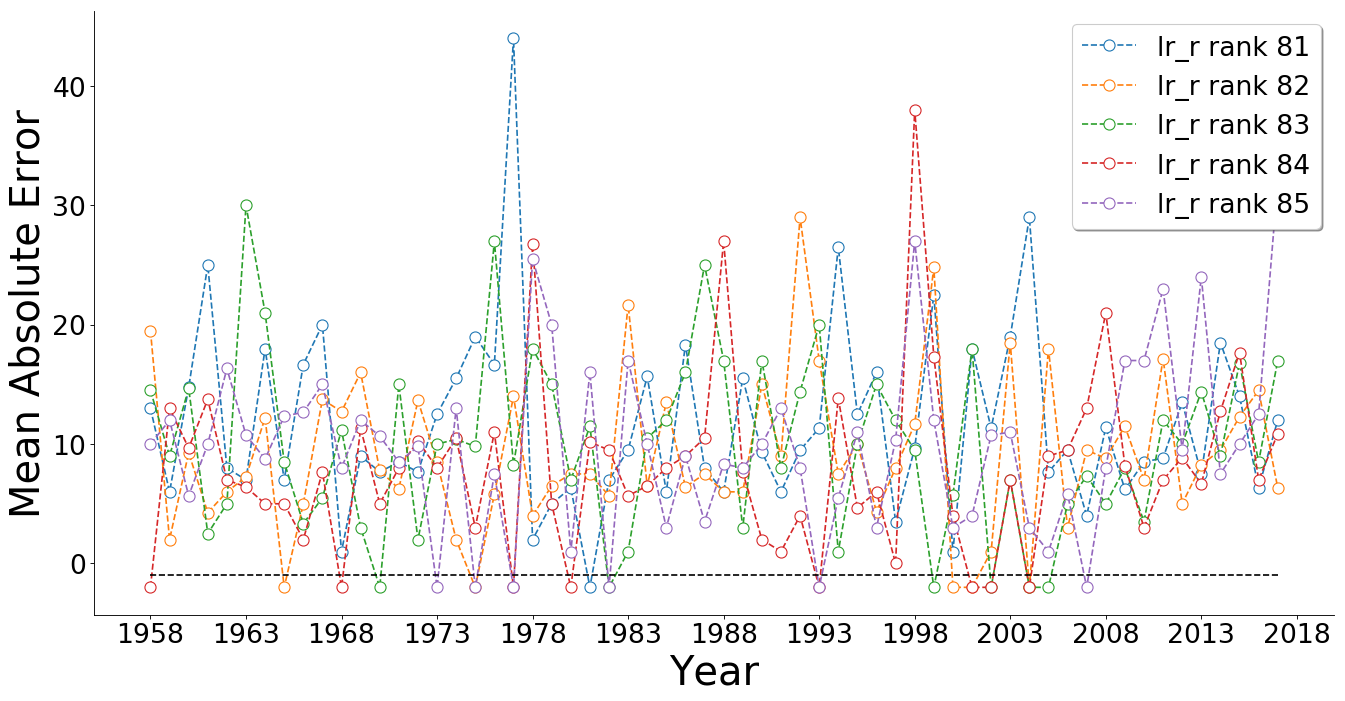

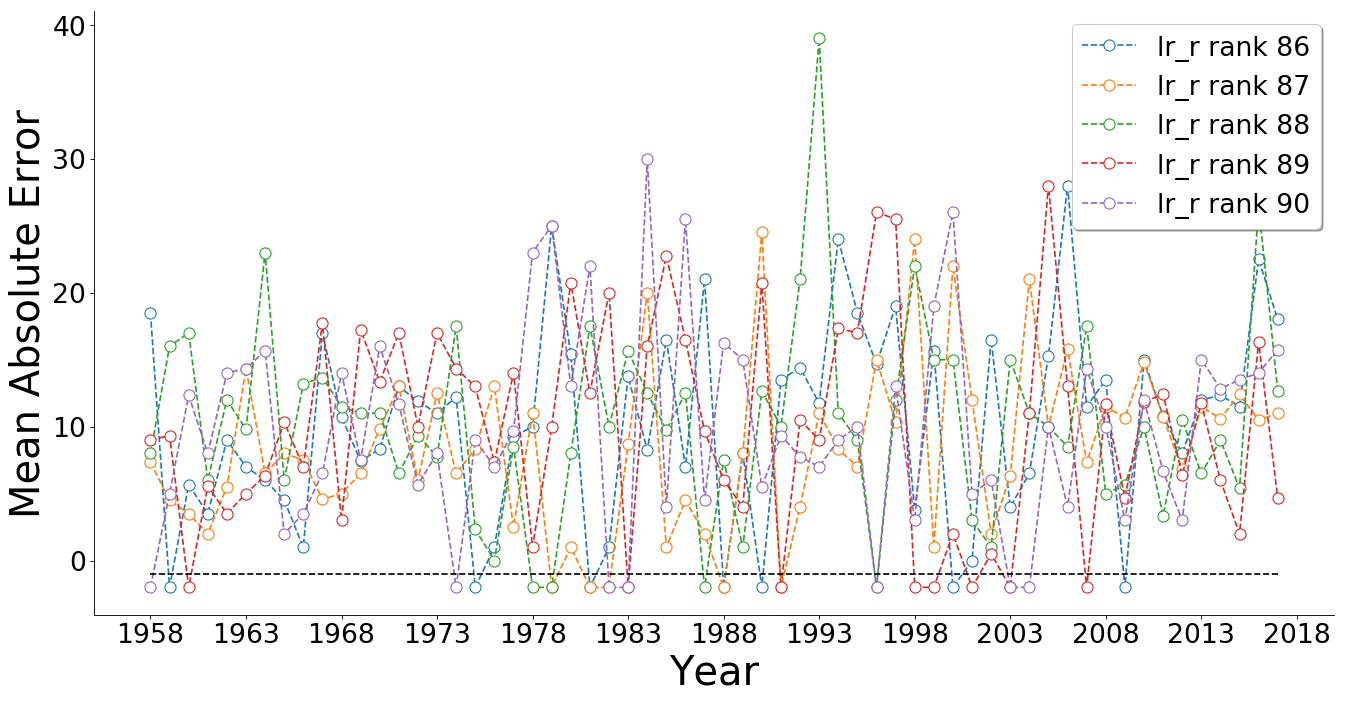

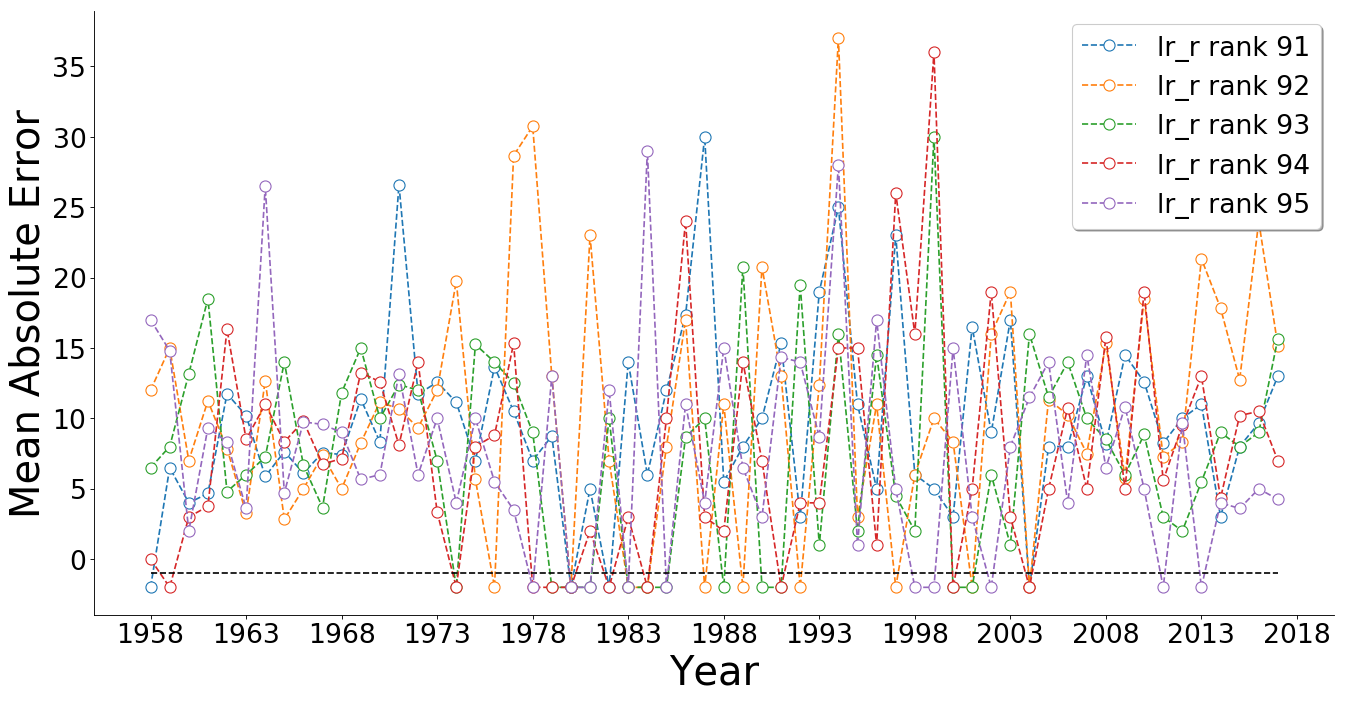

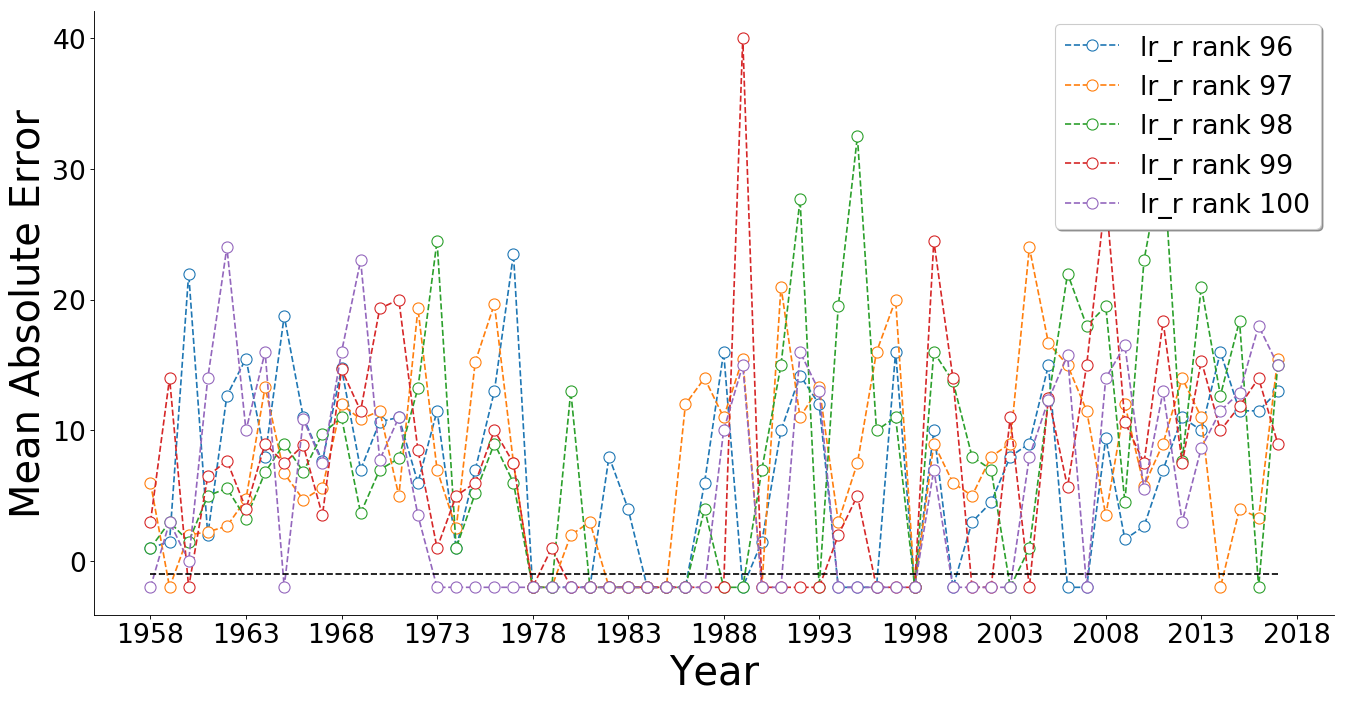

In [23]:
shift_range = 5
for rank in range(1, 101, shift_range):
    compared_feature = [(lr_y_feature, 'strict_rule_pred_by_lr_r', 'lr_r rank {}'.format(val), val) for val in range(rank, rank+shift_range)]
    plot_advanced_error_line_by_year(train=df_train, err_type='mean_absolute_error', compared_feature=compared_feature)


strict_rule_pred_by_lr


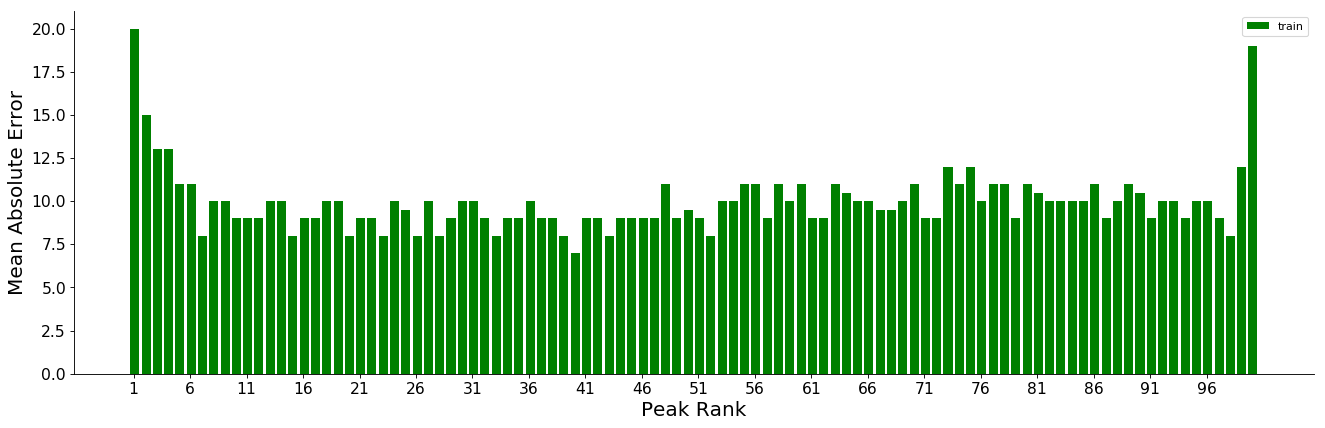

popularity_pred_by_lr_r


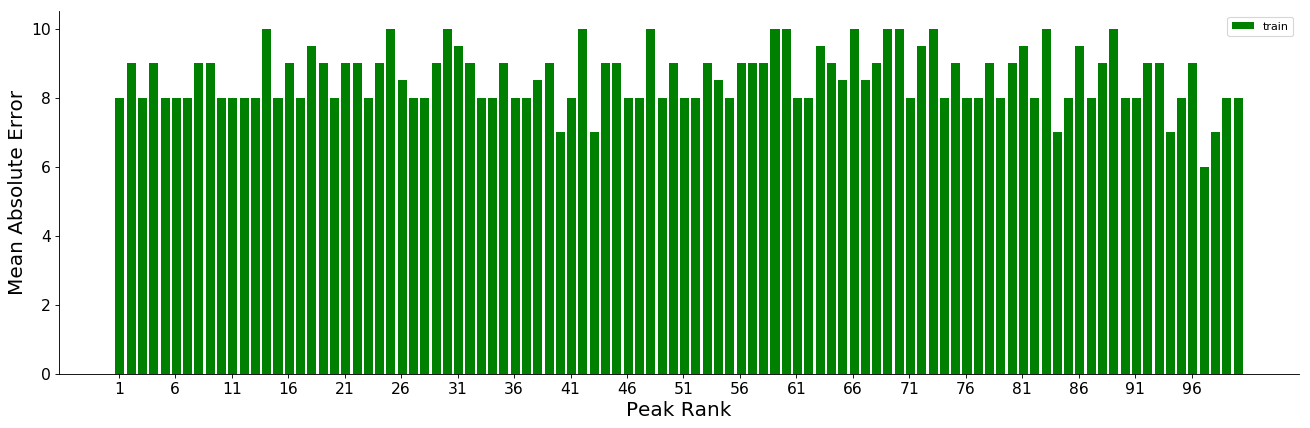

strict_rule_pred_by_lr_y


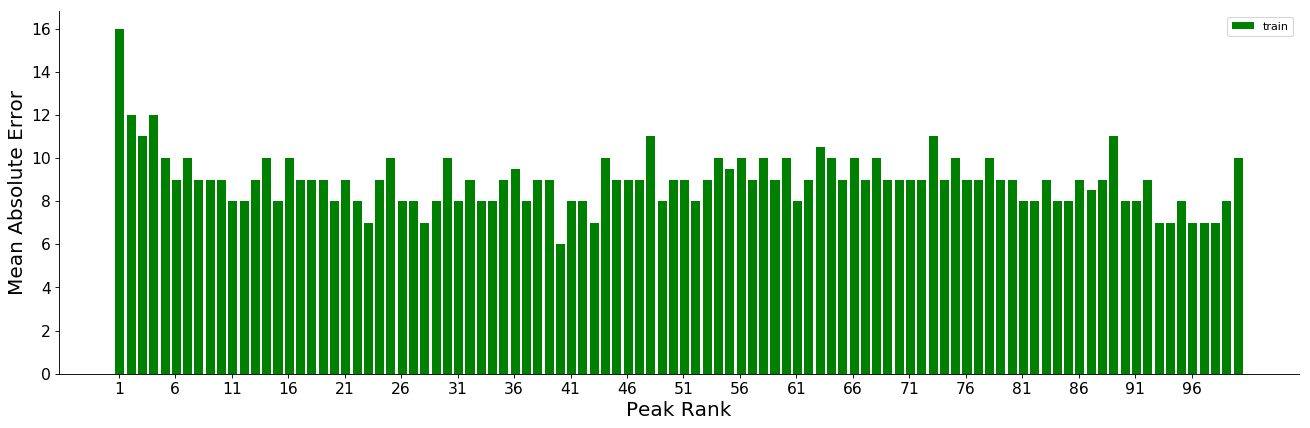

strict_rule_pred_by_lr_r


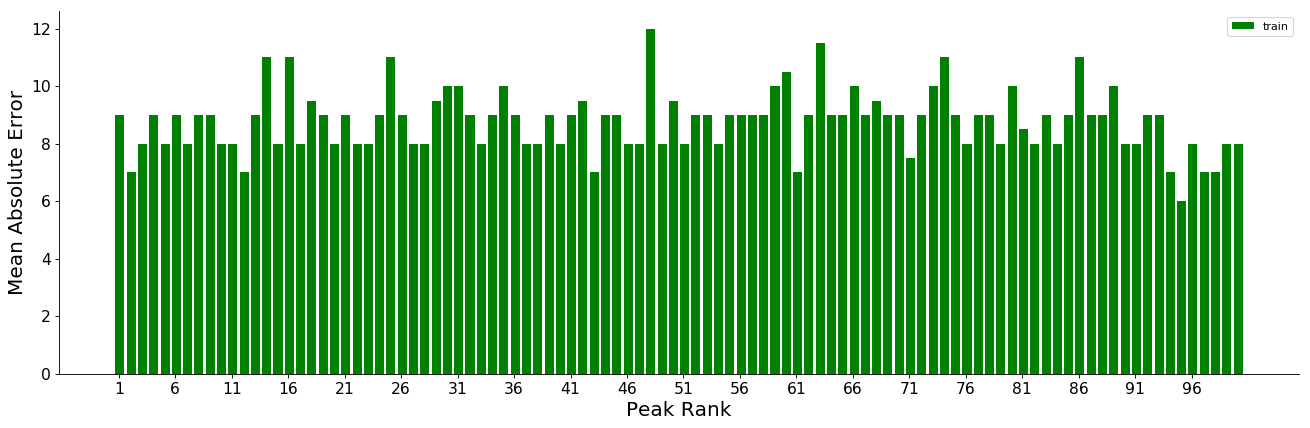

popularity_pred_by_lr


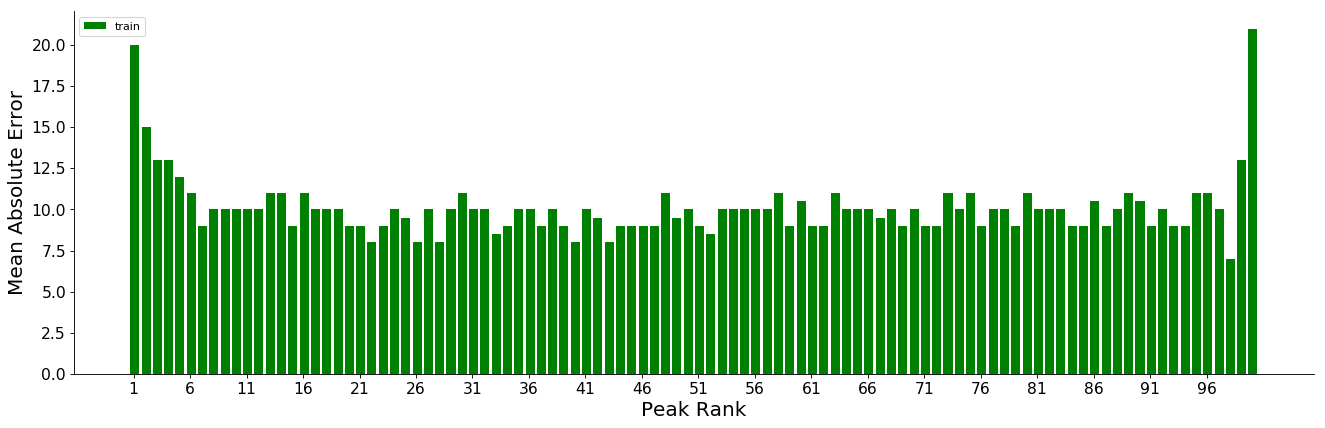

popularity_pred_by_lr_y


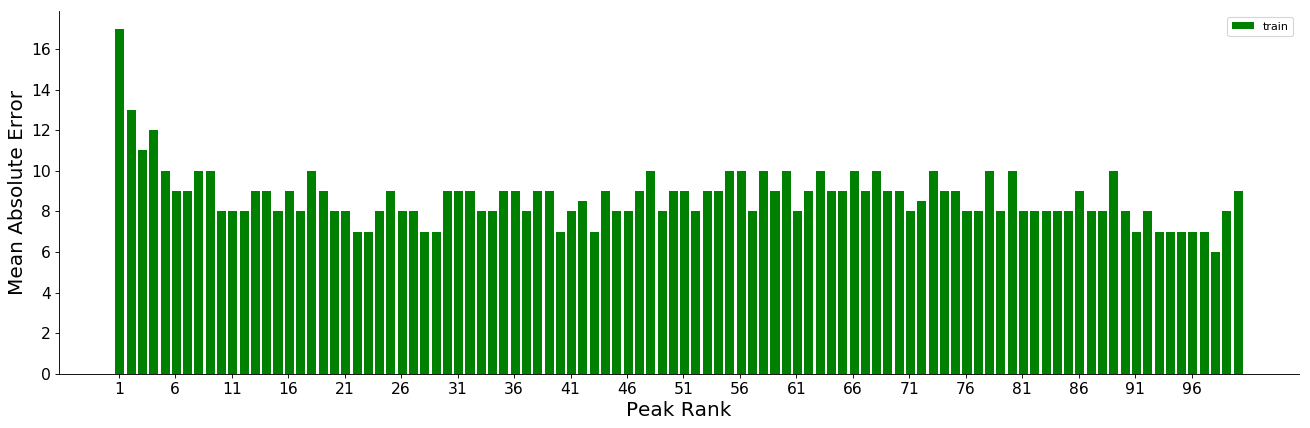

In [28]:
for predicted_feature in list(df_train)[-6:]:
    print(predicted_feature)
    plot_error_by_rank(train = df_train, test = None, err_type = 'median_absolute_error', compared_feature = [lr_y_feature, predicted_feature], model_name = '')


In [25]:
list(df_train)[-10:]

['log_jump_time',
 'log_max_duration',
 'continue_week',
 'reverse_rank',
 'strict_rule_pred_by_lr',
 'popularity_pred_by_lr_r',
 'strict_rule_pred_by_lr_y',
 'strict_rule_pred_by_lr_r',
 'popularity_pred_by_lr',
 'popularity_pred_by_lr_y']

# $\text{Advanced Model - Linear Regression}$

Experiment x features
1. log_reverse_rank, log_weeks_on_chart, jump_time, max_jump_duration, diff_year
2. log_reverse_rank, log_weeks_on_chart, jump_time, normalized(max_jump_duration), diff_year
3. log_reverse_rank, log_weeks_on_chart, jump_time, max_jump_duration, adjusted_diff_year
4. log_reverse_rank, log_weeks_on_chart, jump_time, max_jump_duration, log_continue_week, adjusted_diff_year

y feature
* strict_rule

In [ ]:
possible_lr_x_features = [['log_reverse_rank','log_weeks_on_chart', 'jump_time', 'max_jump_duration', 'diff_year'],
                          ['log_reverse_rank','log_continue_week', 'jump_time', 'max_jump_duration', 'diff_year'],
#                           ['log_reverse_rank', 'log_weeks_on_chart', 'jump_time', 'normalized_max_jump_duration', 'diff_year'],
                          ['log_reverse_rank', 'log_weeks_on_chart', 'jump_time', 'max_jump_duration', 'adjusted_diff_year'],
                          ['log_reverse_rank', 'log_weeks_on_chart', 'jump_time', 'max_jump_duration', 'log_continue_week', 'adjusted_diff_year']]
possible_lr_y_feature = ['strict_rule', 'popularity']

In [ ]:
insert_feature(df_train, log_continue_week, 'log_continue_week')
insert_feature(df_test, log_continue_week, 'log_continue_week')

In [ ]:
mode = 'default'
jump_mode = 'on'
lr_x_features = possible_lr_x_features[0]
lr_y_feature = possible_lr_x_features[1]


for have_jump_time in [False, True]:
    if have_jump_time:
        lr_regr[mode][jump_mode][have_jump_time] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['jump_time'] > 0)] ,
                                                   x_features = lr_x_features,
                                                   y_feature = lr_y_feature,
                                                   intercept = True)
    else:
        lr_regr[mode][jump_mode][have_jump_time] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['jump_time'] == 0)] ,
                                                   x_features = lr_x_features,
                                                   y_feature = lr_y_feature,
                                                   intercept = True)


print('mode: {}, jump_mode: {}\nx: {}\ny: {}'.format(mode, jump_mode, ' '.join(lr_x_features), lr_y_feature))
# lr_regr[mode][jump_mode] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0)] ,
#                                                 x_features = lr_x_features,
#                                                 y_feature = lr_y_feature,
#                                                 intercept = True)
predict_feature_name = lr_y_feature + '_pred_by_lr_r' 
df_train[predict_feature_name] = df_train.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)
df_test[predict_feature_name] = df_test.apply(lambda x: predict_value_by_linear_regression(x, mode, jump_mode), axis=1)

# Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
print('train')
print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression advanced model', lr_y_feature, predict_feature_name)
print('\n test')
print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression advanced model', lr_y_feature, predict_feature_name)

# plot_error_by_rank(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr'], model_name = '')
# plot_error_by_year(train = df_train.loc[(df_train[lr_y_feature] > 0)], test = df_test.loc[(df_test[lr_y_feature] > 0)], err_type = 'mean_absolute_error', compared_feature = [lr_y_feature, 'pred_by_lr'], model_name = '')

# print(lr_regr[mode][jump_mode][False].coef_)
# print(lr_regr[mode][jump_mode][True].intercept_)

In [ ]:
df_train.jump_time[2] == 0

In [ ]:
mode = 'default'
jump_mode = 'on'
for lr_x_features in possible_lr_x_features:
    print(mode, jump_mode)
    print('x features:', ' '.join(lr_x_features))
    lr_regr = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0)] ,
                                              x_features = lr_x_features,
                                              y_feature = lr_y_feature,
                                              intercept = True)
    
    df_train['predicted_by_lr'] = df_train.apply(lambda x: predict_value_by_linear_regression(x, Mode), axis=1)
    df_test['predicted_by_lr'] = df_test.apply(lambda x: predict_value_by_linear_regression(x, Mode), axis=1)

    predict_feature_name = lr_y_feature + '_pred_by_lr_r'
    # Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
    print('train')
    print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression advanced model', lr_y_feature, 'predicted_by_lr')
    print('\n test')
    print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression advanced model', lr_y_feature, 'predicted_by_lr')

    print('\n')

In [ ]:
Mode = mode['rankly']
Jump_Mode = jump_mode['advanced']
for lr_x_features in possible_lr_x_features:
    print('x features:', ' '.join(lr_x_features))
    lr_regr_per_rank = {False:{}, True:{}}
    for have_jump_time in [False, True]:
        for rank in range(1, 101):
            if have_jump_time:
                lr_regr_per_rank[mode][have_jump_time][rank] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['rank'] == rank) & (df_train['jump_time'] > 0)] ,
                                                           x_features = lr_x_features,
                                                           y_feature = lr_y_feature,
                                                           intercept = True)
            else:
                lr_regr_per_rank[have_jump_time][rank] = model_linear_regression(train = df_train.loc[(df_train[lr_y_feature] > 0) & (df_train['rank'] == rank) & (df_train['jump_time'] == 0)] ,
                                                           x_features = lr_x_features,
                                                           y_feature = lr_y_feature,
                                                           intercept = True)

    df_train['advanced_lr_predicted'] = df_train.apply(lambda x: predict_value_by_linear_regression(x, Mode, Jump_Mode), axis=1)
    df_test['advanced_lr_predicted'] = df_test.apply(lambda x: predict_value_by_linear_regression(x, Mode, Jump_Mode), axis=1)

    # Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
    print('train')
    print_statistics_error_info(df_train.loc[df_train[lr_y_feature] > 0], 'linear regression_r base model', lr_y_feature, 'advanced_lr_predicted')
    print('\n test')
    print_statistics_error_info(df_test.loc[df_test[lr_y_feature] > 0], 'linear regression_r base model', lr_y_feature, 'advanced_lr_predicted')
    print('\n')

# $\text{Decision Tree}$

In [ ]:

all_time = {'train':{
                 'great':df_train.loc[df_train.all_time_greatest_artist == 1],
                 'normal':df_train.loc[df_train.all_time_greatest_artist == 0]},
            'test':{
                 'great':df_test.loc[df_test.all_time_greatest_artist == 1],
                 'normal':df_test.loc[df_test.all_time_greatest_artist == 0]},
            }

In [ ]:
model_1_x_features
model_1_y_feature

In [ ]:
lr_regr = model_linear_regression(train = all_time['train']['normal'],
                                          x_features = lr_x_features,
                                          y_feature = lr_y_feature,
                                          intercept = True)
all_time_artist = df_all_time_greatest.apply(lambda x: predict_value_by_linear_regression(x, Mode), axis=1)


# $\text{ML - Random Forest}$

In [ ]:
def model_random_forest(train, x_features = None, y_feature = None, max_depth=2, random_state=0, n_estimators=100, print_msg = False):
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0,n_estimators=100)    
    regr.fit(train[x_features], train[y_feature])
    
    if print_msg:
        print(regr.feature_importances_)

    return regr

## Random Forest with max_depth N, N from 2 to 5

In [ ]:
rf_x_features = ['reverse_rank', 'weeks_on_chart', 'diff_year']
rf_y_feature = 'strict_rule'

In [ ]:
def predict_value_with_random_forest(row_data):
    x_val = row_data[rf_x_features].values
    val = rf_regr.predict([x_val])
    
    if val > 100:
        val = 100
    elif val < 0:
        val = 0
    else:
        val = val.round(decimals = 0)
    
    return val
rf_y_feature = 'popularity'
rf_regr = model_random_forest(train = df_train.loc[(df_train[rf_y_feature] > 0)] ,
                                   x_features = rf_x_features,
                                   y_feature = rf_y_feature,
                                   max_depth = 5)
df_train['predicted_by_rf'] = df_train.apply(predict_value_with_random_forest, axis=1)
df_test['predicted_by_rf'] = df_test.apply(predict_value_with_random_forest, axis=1)

# Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
print('train')
print_statistics_error_info(df_train.loc[df_train[rf_y_feature] > 0], 'random forest base model', rf_y_feature, 'predicted_by_rf')
print('\n test')
print_statistics_error_info(df_test.loc[df_test[rf_y_feature] > 0], 'random forest base model', rf_y_feature, 'predicted_by_rf')

# $\text{ML - Random Forest}_r$
## with max_depth N, N = {1, 2, 3, 4, 5, 10}
## tend to be overfitting

In [ ]:
def predict_value_with_random_forest_by_rank(row_data):
    rank = row_data['rank']
    x_val = row_data[rf_x_features].values
    val = rf_regr_per_rank[rank].predict([x_val])
    
    if val > 100:
        val = 100
    elif val < 0:
        val = 0
    else:
        val = val.round(decimals = 0)
    
    return val

rf_regr_per_rank = {}

for rank in range(1, 101):
    rf_regr_per_rank[rank] = model_random_forest(train = df_train.loc[(df_train[rf_y_feature] > 0) & (df_train['rank'] == rank)] ,
                                                       x_features = rf_x_features,
                                                       y_feature = rf_y_feature,
                                                       max_depth=2)

df_train['rf_r_predicted'] = df_train.apply(predict_value_with_random_forest_by_rank, axis=1)
df_test['rf_r_predicted'] = df_test.apply(predict_value_with_random_forest_by_rank, axis=1)

# Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
print('train')
print_statistics_error_info(df_train.loc[df_train[rf_y_feature] > 0], 'random forest_r base model', rf_y_feature, 'rf_r_predicted')
print('\n test')
print_statistics_error_info(df_test.loc[df_test[rf_y_feature] > 0], 'random forest_r base model', rf_y_feature, 'rf_r_predicted')

# $\text{ML - Kneighbor}$

In [ ]:
def model_kneighbor(train, x_features, y_feature, n_neighbors = 3):
    neigh = KNeighborsRegressor(n_neighbors= n_neighbors)
    neigh.fit(train[x_features], train[y_feature])

    return neigh

In [ ]:
def predict_value_with_kneighbor(row_data):
    x_val = row_data[model_3_x_features].values
    val = model_3_regr.predict([x_val])
    
    if val > 100:
        val = 100
    elif val < 0:
        val = 0
    else:
        val = val.round(decimals = 0)
    
    return val
    

model_3_x_features = ['rank', 'weeks_on_chart', 'diff_year']
model_3_y_feature = 'strict_rule'

model_3_regr = model_kneighbor(train = df_train.loc[(df_train[model_3_y_feature] > 0)] ,
                                   x_features = model_3_x_features,
                                   y_feature = model_3_y_feature,
                                   n_neighbors = 10)
df_train['model_3_predicted'] = df_train.apply(predict_value_with_kneighbor, axis=1)
df_test['model_3_predicted'] = df_test.apply(predict_value_with_kneighbor, axis=1)

# Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
print('train')
print_statistics_error_info(df_train.loc[df_train[model_3_y_feature] > 0], 'random forest base model', model_3_y_feature, 'model_3_predicted')
print('\n test')
print_statistics_error_info(df_test.loc[df_test[model_3_y_feature] > 0], 'random forest base model', model_3_y_feature, 'model_3_predicted')

# $\text{ML - Kneighbor}_r$

In [ ]:
def predict_value_with_kneighbor_by_rank(row_data):
    rank = row_data['rank']
    x_val = row_data[model_3_x_features].values
    val = kneigh_regr_per_rank[rank].predict([x_val])
    
    if val > 100:
        val = 100
    elif val < 0:
        val = 0
    else:
        val = val.round(decimals = 0)
    
    return val

kneigh_regr_per_rank = {}

for rank in range(1, 101):
    kneigh_regr_per_rank[rank] = model_kneighbor(train = df_train.loc[(df_train[model_3_y_feature] > 0) & (df_train['rank'] == rank)] ,
                                                       x_features = model_3_x_features,
                                                       y_feature = model_3_y_feature,
                                                       n_neighbors = 10)

df_train['model_3_r_predicted'] = df_train.apply(predict_value_with_kneighbor_by_rank, axis=1)
df_test['model_3_r_predicted'] = df_test.apply(predict_value_with_kneighbor_by_rank, axis=1)

# Calcluate the Mean Absolute Error, Median Absolute Error, Mean Squared Error
print('train')
print_statistics_error_info(df_train.loc[df_train[model_3_y_feature] > 0], 'random forest_r base model', model_3_y_feature, 'model_3_r_predicted')
print('\n test')
print_statistics_error_info(df_test.loc[df_test[model_3_y_feature] > 0], 'random forest_r base model', model_3_y_feature, 'model_3_r_predicted')

In [ ]:

plot_error_by_rank(df_train.loc[df_train[y_feature] > 0], 
                 df_test.loc[df_test[y_feature] > 0],
                 err_type = 'median_absolute_error',
                 compared_feature = [y_feature, 'predict'],
                 model_name = '')

plot_error_by_rank(df_train.loc[df_train[y_feature] > 0], 
                 df_test.loc[df_test[y_feature] > 0],
                 err_type = 'mean_absolute_error',
                 compared_feature = [y_feature, 'predict'],
                 model_name = '')

plot_error_by_rank(df_train.loc[df_train[y_feature] > 0], 
                 df_test.loc[df_test[y_feature] > 0],
                 err_type = 'mean_squared_error',
                 compared_feature = [y_feature, 'predict'],
                 model_name = '')
# plot_mae_by_year(df_test.loc[df_test['strict_rule'] > 0], df_train.loc[df_train['strict_rule'] > 0])

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
x = np.arange(1, 101)
plt.bar(x,train_stats['MAE'], color = 'green', width = 0.4, label='train')
plt.bar(x + 0.4, test_stats['MAE'], color = 'orange', width = 0.4, label='test')
plt.xlabel("Peak Rank",fontsize=18)
plt.ylabel("Popularity Difference",fontsize=18)
plt.title("Mean Absolute Error by Rank (Base Model)",fontsize=18)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
print(mean_absolute_error(df_train['strict_rule'], df_train['predict']))
print(mean_squared_error(df_train['strict_rule'], df_train['predict']))
print(mean_absolute_error(df_test['strict_rule'], df_test['predict']))
print(mean_squared_error(df_test['strict_rule'], df_test['predict']))

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
x = np.arange(1, 101)
plt.bar(x,train_stats['MAE'], color = 'green', width = 0.4, label='train')
plt.bar(x + 0.4, test_stats['MAE'], color = 'orange', width = 0.4, label='test')
plt.xlabel("Peak Rank",fontsize=18)
plt.ylabel("Popularity Difference",fontsize=18)
plt.title("Mean Absolute Error by Rank (Base Model)",fontsize=18)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

plt.figure(figsize=(20, 6), dpi=80)
x = np.arange(100)
plt.bar(x,train_stats['MSE'], color = 'y', width = 0.4, label='train')
plt.bar(x + 0.4, test_stats['MSE'], color = 'r', width = 0.4, label='test')
plt.xlabel("Peak Rank",fontsize=18)
plt.ylabel("Popularity Difference",fontsize=18)
plt.title("Mean Square Error of Popularity by Rank (Base Model)",fontsize=18)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
x_features = [['log_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'diff_year'],
              ['log_reverse_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'diff_year'],
              ['log_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'adjusted_diff_year'],
              ['log_reverse_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'adjusted_diff_year']]
y_features = ['strict_rule']

# df_train, df_test = train_test_split(df_all, test_size = test_size)
model_info_stats = {}
stats = {}
for idx, x_feature in enumerate(x_features):
    for y_feature in y_features:
#         for rank in range(1, 100):
        model_info = model_two(train = df_train.loc[(df_train[y_feature] > 0) & (df_train['rank'] == rank)] , \
                               test = df_test.loc[(df_test[y_feature] > 0) & (df_test['rank'] == rank)], \
                               x_features = x_feature, \
                               y_feature = y_feature, \
                               intercept = True)
        if idx not in stats:
            stats[idx] = {'train':[], 'test':[]}
        stats[idx]['train'].append(model_info['info']['train']['MAE'])
        stats[idx]['test'].append(model_info['info']['test']['MAE'])  

        if idx not in model_info_stats:
            model_info_stats[idx] = []
        model_info_stats[idx].append(model_info)  

In [ ]:
stats = {'strict_rule': {}, 'popularity': {}}
mae_error = {'train': [], 'test': []}
mse_error = {'train': [], 'test': []}

    
MAE = {'strict_rule': [], 'popularity': []}
MSE = {'strict_rule': [], 'popularity': []}
for y_feature in ['strict_rule']:
    for x_features in [['log_reverse_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'diff_year']]:
        for rank in range(1, 101):
            model_info = model_two(train = df_train_wo_jump.loc[(df_train_wo_jump[y_feature] > 0)& (df_train_wo_jump['rank'] == rank)] , \
                            test = df_test_wo_jump.loc[(df_test_wo_jump[y_feature] > 0) & (df_test_wo_jump['rank'] == rank)], \
                            x_features = x_features, \
                            y_feature = y_feature, \
                            intercept = True)

            mae_error['train'].append(model_info['info']['train']['MAE'])
            mse_error['train'].append(model_info['info']['train']['MSE'])
            mae_error['test'].append(model_info['info']['test']['MAE'])
            mse_error['test'].append(model_info['info']['test']['MSE'])

# $\text{Gradient Boosting Regressor}$

In [ ]:
list(df_train)

In [ ]:
GBM_x_features = ['rank', 'jump_time', 'max_jump_duration', 'diff_year', 'all_time_greatest_artist',
                  'artist_died', 'christmas', 'church', 'classical', 'in_commercials',
                  'concerts', 'easter', 'fourth_of_july', 'funerals', 'graduations',
                  'grammys', 'halloween', 'in_movie_clueless', 'in_movies', 'in_plays', 'in_tv_shows',
                  'karaoke', 'lullabies', 'mtv_awards', 'phone_call', 'politicians',
                  'sporting_events', 'tv_show_theme', 'weddings', 'won_oscars', 'wordcup']
est.set_params(n_estimators=200, warm_start=True) 
est = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, random_state=0, loss='ls').fit(df_train.loc[df_train['strict_rule'] > 0][GBM_x_features], df_train['strict_rule'])
mean_squared_error(df_test.loc[df_test['strict_rule'] > 0]['strict_rule'], est.predict(df_test.loc[df_test['strict_rule'] > 0][GBM_x_features]))    

# Advanced Model I
$
\text{popularity} = \text{rank}^{C_r}(\text{weeks_on_chart})^{C_w}(\text{jump_time})^{C_j} (\text{max_duration})^{C_m}e^{C_t \Delta t + C_i}
$


$$
\begin{align*}
\log(\text{popularity}) =& C_r\log(\text{rank}) + C_w\log(\text{weeks_on_chart}) \\&+ C_j\log(\text{jump_time}) + C_m\log(\text{max_duration}) + {C_t \Delta t} + C_i
\end{align*}
$$

In [ ]:
for y_feature in ['strict_rule']:
    for x_features in [['log_reverse_rank', 'log_weeks_on_chart', 'log_jump_time', 'log_max_duration', 'diff_year']]:
#         for rank in range(1, 101):
            model_info = model_two(train = df_train.loc[(df_train[y_feature] > 0)& (df_train['rank'] == rank)] , \
                            test = df_test.loc[(df_test[y_feature] > 0) & (df_test['rank'] == rank)], \
                            x_features = x_features, \
                            y_feature = y_feature, \
                            intercept = True)

            mae_error['train'].append(model_info['info']['train']['MAE'])
            mse_error['train'].append(model_info['info']['train']['MSE'])
            mae_error['test'].append(model_info['info']['test']['MAE'])
            mse_error['test'].append(model_info['info']['test']['MSE'])

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
x = np.arange(0, 100)
plt.bar(x,mae_error['train'], color = 'green', width = 0.25, label='train')
plt.bar(x + 0.4, mae_error['test'], color = 'orange', width = 0.25, label='test')
plt.xlabel("Peak Rank",fontsize=18)
plt.ylabel("Popularity Difference",fontsize=18)
plt.title("Mean Absolute Error by Rank (Base Model)",fontsize=18)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)
x = np.arange(100)
plt.bar(x,mse_error['train'], color = 'y', width = 0.25, label='train')
plt.bar(x + 0.4, mse_error['test'], color = 'r', width = 0.25, label='test')
plt.xlabel("Peak Rank",fontsize=18)
plt.ylabel("Popularity Difference",fontsize=18)
plt.title("Mean Square Error of Popularity by Rank (Base Model)",fontsize=18)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()

In [ ]:
model_info['train']['pop_difference'] = model_info['train'].apply(lambda row: row.strict_rule - row.predicted, axis = 1)
model_info['train']['abs_pop_difference'] = model_info['train']['pop_difference'].apply(lambda val: np.abs(val))

In [ ]:
model_info['train'].sort_values(by=['pop_difference'],inplace=True)
underperform=model_info['train'].head(10)
overperform=model_info['train'].tail(10)

In [ ]:
plt.plot(mae_error)

In [ ]:
model_info_stats[2][0]['train']['year']

In [ ]:
rank = 13
plt.scatter(model_info_stats[1]['train']['year'], model_info_stats[2]['train']['strict_rule'],  color='blue')
plt.scatter(model_info_stats[1]['train']['year'], model_info_stats[2]['train']['predicted'],  color='red')
# plt.plot(model_info_stats[2][0]['train']['year'], model_info_stats[2][0]['train']['popularity'])

# Test Feature Combination

In [ ]:
features = ['log_weeks_on_chart', 'log_jump_time', 'log_max_duration']
features_set_w_dy = []
features_set_w_ady = []

for idx in range(len(features) + 1):
    set_combinations = itertools.combinations(features, idx)
    for subset in set_combinations:
        features_set_w_dy.append(list(subset))
        features_set_w_ady.append(list(subset))
        features_set_w_dy[-1].extend(['log_rank', 'diff_year'])
        features_set_w_ady[-1].extend(['log_rank', 'adjusted_diff_year'])

Experiment_Mode = False
if not Experiment_Mode:
    print(len(features_set_w_dy))
    for features_opt0, features_opt1 in zip (features_set_w_dy, features_set_w_ady):
        print(features_opt0)
        print(features_opt1, '\n')

In [ ]:
possible_x_features = features_set_w_ady + features_set_w_dy

In [ ]:
possible_x_features

In [ ]:
# log_rank, log_weeks_on_chart, log_jump_time, log_max_duration, diff_year, adjusted_diff_year
stats = {'strict_rule':{}, 'lenient_rule':{}, 'popularity':{}}
mae_error = {'train':[], 'test':[]}
for _ in range(20):
    df_train, df_test = train_test_split(df_all, test_size = test_size)
    
    MAE = {'strict_rule':[], 'lenient_rule':[], 'popularity':[]}
    y_features = ['strict_rule', 'lenient_rule', 'popularity']
    y_features = ['strict_rule']
    for y_feature in y_features:
#         print('y features:', y_feature)
#         print()
#         test_x_features = [['log_weeks_on_chart','log_jump_time','log_max_duration','log_rank','adjusted_diff_year']]
        for x_features in possible_x_features:
    #         print('    x features:', x_features)
            model_info = model_two(train = df_train.loc[(df_train[y_feature] > 0)] , \
                                           test = df_test.loc[(df_test[y_feature] > 0)], \
                                           x_features = x_features, \
                                           y_feature = y_feature, \
                                           intercept = True)
#             for rank in range(1, 101):
#                 model_info = model_two(train = df_train.loc[(df_train[y_feature] > 0) & (df_train['rank'] == rank)] , \
#                                            test = df_test.loc[(df_test[y_feature] > 0) & (df_test['rank'] == rank)], \
#                                            x_features = x_features, \
#                                            y_feature = y_feature, \
#                                            intercept = True)
            info = model_info['info']
            mae_error['train'].append(info['train']['MAE'])
            mae_error['test'].append(info['test']['MAE'])
            MAE[y_feature].append([x_features, \
                                   info['coef'], \
                                   info['intercept'], \
                                   info['train']['MAE'], \
                                   info['train']['MSE'], \
                                   info['train']['Variance'], \
                                   info['test']['MAE'], \
                                   info['test']['MSE'], \
                                   info['test']['Variance']])
            if x_features == ['log_rank', 'diff_year'] or \
               x_features == ['log_rank', 'adjusted_diff_year']:
                print('base model:', \
                      x_features, '\n'\
                      'coef:', info['coef'], info['intercept'], '\n', \
                      info['train']['MAE'], \
                      info['train']['MSE'], \
                      info['train']['Variance'], \
                      info['test']['MAE'], \
                      info['test']['MSE'], \
                      info['test']['Variance'], '\n')

        local_info = min(MAE[y_feature],key=itemgetter(3))
        x_features_str = '-'.join(local_info[0])
        if x_features_str in stats[y_feature]:
            stats[y_feature][x_features_str] += 1
        else:
            stats[y_feature][x_features_str] = 1
#         print('minimal error model:', \
#               local_info[0], '\n', \
#               'coef:', local_info[1:3], '\n', \
#               local_info[3:], '\n')


    #         print('\n')
    #     print('\n')
    # print(df_train['popularity'].values.shape)
    # print(df_train['strict_rule'].apply(lambda x: 0 if x == 0 else np.log(x)).values.shape)
    # list(df_train)


In [ ]:
plt.plot(mae_error['train'])
plt.plot(mae_error['test'])

In [ ]:
for major_key in stats.keys():
    print(major_key)
    for minor_key in stats[major_key].keys():
        print(minor_key, stats[major_key][minor_key])
    print('\n')

# Visualization

In [ ]:
def plot_absolute_error(predict_train, predict_test):
     # calculate absolute error of each year 
    predicted_test_year = predict_test.groupby('year')
    min_year = predict_test['year'].min()
    max_year = predict_test['year'].max()+1    
    
    error_year=[]
    for index, group in predicted_test_year:
        error= np.array(group['popularity']-group['predictedPopularity'])
        length=error.shape[0]
        error=np.abs(error)
        total_error=error.sum() 
        total_error=total_error/length
        error_year.append(total_error) 
    
    year = range(min_year, max_year)
    
    print("the mean absolute error of different years is: ")
    print(sum(error_year)/len(error_year))
    plt.figure(figsize=(20, 6), dpi=80)
    plt.plot(year,error_year)
    plt.xlabel("Year")
    plt.ylabel("Absolute Error")
    plt.title("for test case")
    plt.show()
    
    
    # PLOT BAR FIRUGE     
    plt.figure(figsize=(20, 6), dpi=80)
    plt.bar(year,error_year)
    plt.xlabel("Year",fontsize=18)
    plt.ylabel("Absolute Error",fontsize=18)
    plt.title("Absolute Error of Every Year",fontsize=18)
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    plt.show()

# Add New Features

In [ ]:
def advanced_insert_feature(df, func = None, feature_name = None):
    if not feature_name:
        raise ('Empty feature')

    new_data = df.apply(lambda x: func(x, feature_name), axis = 1)
    df.insert(df.shape[1], feature_name, new_data)
    
def insert_feature(df, func = None, feature_name = None):
    if not feature_name:
        raise ('Empty feature')

    new_data = df.apply(func, axis = 1)
    df.insert(df.shape[1], feature_name, new_data)

def new_feature(row_data, feature_name = None):
    if not feature_name:
        raise ('Empty feature')

    songid = row_data['song']
    
    if df_features[feature].loc[df_features[feature]['song'] == songid].shape[0] > 0:
        return 1
    else:
        return 0

In [ ]:
df_features = {}
csv_files = [f for f in os.listdir('.') if os.path.isfile(f)]
for csv_file in csv_files:
    if 'csv' in csv_file and 'songs' in csv_file:
        feature = csv_file.split('.')[0]
        df_features[feature] = pd.read_csv(csv_file)
        df_features[feature]['songid'] = df_features[feature][['song', 'artist']].apply(lambda x: ''.join(x), axis=1)

df_features = {}
csv_files = ['songs-used-in-movies.csv',\
            'songs-used-in-tv-shows.csv',\
            'songs-used-in-commercials.csv']
for csv_file in csv_files:
    feature = csv_file.split('.')[0]
    df_features[feature] = pd.read_csv(csv_file)
    df_features[feature]['songid'] = df_features[feature][['song', 'artist']].apply(lambda x: ''.join(x), axis=1)

In [ ]:
for feature in df_features.keys():
    advanced_insert_feature(df_train, new_feature, feature)
    advanced_insert_feature(df_test, new_feature, feature)

In [ ]:
# create new fit feature
for feature in df_features.keys():
    new_feature = 'fit-' + feature
    df_train[new_feature] = df_train.apply(lambda row: np.log(row[feature] + 1), axis=1)
    df_test[new_feature] = df_test.apply(lambda row: np.log(row[feature] + 1), axis=1)

In [ ]:
df_train['new_feature'] = df_train[list(df_features)].apply(lambda x: 1 if any(x) else 0, axis=1)
df_test['new_feature'] = df_test[list(df_features)].apply(lambda x: 1 if any(x) else 0, axis=1)

In [ ]:
df_train['sum_feature'] = df_train[list(df_features)].apply(lambda x: np.log(sum(x)) if any(x) else 0, axis=1)
df_test['sum_feature'] = df_test[list(df_features)].apply(lambda x: np.log(sum(x)) if any(x) else 0, axis=1)

In [ ]:
df_train['log_weeks_on_charts'] = df_train['weeks_on_chart'].apply(lambda x: np.log(x))
df_test['log_weeks_on_charts'] = df_test['weeks_on_chart'].apply(lambda x: np.log(x))

In [ ]:
df_train['log_jump_time'] = df_train['jump_time'].apply(lambda x: np.log(x**2) if x > 0 else 0)
df_test['log_jump_time'] = df_test['jump_time'].apply(lambda x: np.log(x**2) if x > 0 else 0)
df_train['log_max_jump_duration'] = df_train['max_jump_duration'].apply(lambda x: np.log(x**2) if x > 0 else 0)
df_test['log_max_jump_duration'] = df_test['max_jump_duration'].apply(lambda x: np.log(x**2) if x > 0 else 0)

In [ ]:
list(df_test)

In [ ]:
list(df_features.keys())

# model -fit-movie, fit-tv-show, fit-commercials

In [ ]:
def evaluation_featured_model(train = df_train, test = df_test, x_features = None, y_feature = None, intercept = True, full_info = False):
    x_train = train[x_features].values  
    y_train = train[y_feature].values
    x_test = test[x_features].values
    y_test = test[y_feature].values
    
    regr = linear_model.LinearRegression(fit_intercept=intercept) # with intercept 
    regr.fit(x_train, y_train)
    ytest_pred = regr.predict(x_test)
    ytrain_pred=regr.predict(x_train)
    
    if full_info:
        print('Coefficients: \n', regr.coef_)
        print('Intercept when fit_intercept=True : {:.5f}'.format(regr.intercept_))
    
    print("Mean squared error for test case is: %.3f"% mean_squared_error(y_test, ytest_pred))
    if full_info:
        print('Variance score for test case is: %.3f' % r2_score(y_test, ytest_pred))
    print("Mean squared error for train case is: %.3f"% mean_squared_error(y_train, ytrain_pred))
    if full_info:
        print('Variance score for test case is: %.3f' % r2_score(y_train, ytrain_pred))

# df_train_mid=df_train.assign(predictedlogP=pd.Series(ytrain_pred))
# df_test_mid=df_test.assign(predictedlogP=pd.Series(ytest_pred))
    
# predict_train=df_train_mid.assign(predictedPopularity=pd.Series( np.exp(df_train_mid['predictedlogP'])))
# predict_test=df_test_mid.assign(predictedPopularity=pd.Series( np.exp(df_test_mid['predictedlogP'])))

In [ ]:
fit_features = ['fit-'+ feature for feature in df_features.keys()]
print(fit_features)

In [ ]:
start_year = 1958
end_year = 2005
for rank in ['logRank']:
    for pop in ['logPopularity','logNewPopularity']:
        print(rank, pop)
        

        print('linear regression - base model')
        evaluation_featured_model(train=df_train.loc[df_train.year.isin([start_year, end_year])], test=df_test, x_features=[rank, 'Y_year'], y_feature=pop)

        print('\nlinear regression - base model 1')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])], test=df_test,x_features=[rank, 'Y_year', 'log_weeks_on_charts'], y_feature=pop)
        
        print('\nlinear regression - base model 2')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])],\
                                  test=df_test\
                                  ,x_features=[rank, 'Y_year', 'log_weeks_on_charts'],\
                                  y_feature=pop)
        
        print('\nlinear regression - base model 3')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])],\
                                  test=df_test,\
                                  x_features=[rank,\
                                              'Y_year',\
                                              'log_weeks_on_charts',\
                                              'log_jump_time'],\
                                  y_feature=pop)
        
        print('\nlinear regression - base model 4')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])],\
                                  test=df_test,\
                                  x_features=[rank,\
                                              'Y_year',\
                                              'log_weeks_on_charts',\
                                              'log_jump_time',\
                                              'log_max_jump_duration'],\
                                  y_feature=pop)
        
        print('\nlinear regression - base model 4')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])],\
                                  test=df_test,\
                                  x_features=[rank,\
                                              'Y_year',\
                                              'log_weeks_on_charts',\
                                              'log_jump_time',\
                                              'log_max_jump_duration',\
                                              'all_time_greatest_artist'],\
                                  y_feature=pop)
        
        print('\nlinear regression - advanced model')
        features = [rank, 'Y_year', 'log_weeks_on_charts', 'log_jump_time', 'log_max_jump_duration']
        features.extend(fit_features)
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])], test=df_test,x_features=features, y_feature=pop)
        
        print('\nlinear regression - all as one model')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])], test=df_test,x_features=[rank, 'Y_year', 'log_weeks_on_charts', 'log_jump_time', 'log_max_jump_duration','new_feature'], y_feature=pop)
        
        print('\nlinear regression - sum all feature model')
        evaluation_featured_model(train=df_train[df_train.year.isin([start_year, end_year])], test=df_test,x_features=[rank, 'Y_year', 'log_weeks_on_charts', 'log_jump_time', 'log_max_jump_duration','sum_feature'], y_feature=pop)
        print('\n')

In [ ]:
print(df_train.loc[(df_train['songs-used-in-commercials'] == 1)].shape[0])
print(df_train.loc[(df_train['songs-used-in-movies'] == 1)].shape[0])
print(df_train.loc[(df_train['songs-used-in-tv-shows'] == 1)].shape[0])
print(df_train.loc[(df_train['songs-used-in-movies'] == 1) |\
                   (df_train['songs-used-in-tv-shows'] == 1) |\
                   (df_train['songs-used-in-commercials'] == 1)].shape[0])

In [ ]:
df_features.keys()

In [ ]:
corr = df_train[list(df_features.keys())].corr()
corr.style.background_gradient()

In [ ]:
features = [rank, 'Y_year', 'log_weeks_on_charts', 'log_jump_time', 'log_max_jump_duration']
features.extend(fit_features)
features.remove('fit-songs-for-wedding-anniversaries')
corr = df_train[features].corr()
corr.style.background_gradient()